**Goal**: investigate the agreement between integrated gradients and activation patching when the baselines are similar, across a variety of circuit tasks.

**Tasks**:

- Indirect Object Identification (![Wang et al, 2023](https://arxiv.org/pdf/2211.00593)): consists of inputs like “When Mary and John went to the store, John gave a bottle of milk to”; models are expected to predict “Mary”. Performance measured using logit differences.

- Gender-Bias (![Vig et al, 2020](https://proceedings.neurips.cc/paper/2020/hash/92650b2e92217715fe312e6fa7b90d82-Abstract.html)): designed to study gender bias in LMs. Gives models inputs like “The nurse said that”; biased models tend to complete this sentence with “she”. Performance measured using logit differences.

- Greater-Than (![Hanna et al., 2023](https://arxiv.org/abs/2305.00586)): models receive input like “The war lasted from the year 1741 to the year 17”, and must predict a valid two-digit end year, i.e. one that is greater than 41. Performance measured using probability differences. 

- Capital–Country (![Hanna et al., 2024](https://arxiv.org/abs/2403.17806)): models receive input like “Tirana, the capital of” and must output the corresponding country (Albania). Corrupted instances contain another capital (e.g. Brasilia) instead. Performance measured using logit differences.

# Set up

In [1]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from captum.attr import LayerIntegratedGradients

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

/vol/bitbucket/mwl21/fypvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from enum import Enum
from torch.utils.data import Dataset, DataLoader

class Task(Enum):
    IOI = 1
    GENDER_BIAS = 2
    GREATER_THAN = 3
    CAPITAL_COUNTRY = 4
    SVA = 5
    HYPERNYMY = 6

# Implementation of dataset loader based on https://github.com/hannamw/eap-ig-faithfulness

def collate_EAP(xs, task: Task):
    clean, corrupted, labels = zip(*xs)
    clean = list(clean)
    corrupted = list(corrupted)
    if task != Task.HYPERNYMY:
        labels = torch.tensor(labels)
    return clean, corrupted, labels

class TaskDataset(Dataset):
    def __init__(self, task: Task):
        filename = task.name.lower()
        self.task = task
        self.df = pd.read_csv(f'datasets/{filename}.csv')

    def __len__(self):
        return len(self.df)
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)

    def head(self, n: int):
        self.df = self.df.head(n)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        label = None

        if self.task == Task.IOI:
            label = [row['correct_idx'], row['incorrect_idx']]
            return row['clean'], row['corrupted_hard'], label
        
        if self.task == Task.GREATER_THAN:
            label = row['correct_idx']
        elif self.task == Task.HYPERNYMY:
            answer = torch.tensor(eval(row['answers_idx']))
            corrupted_answer = torch.tensor(eval(row['corrupted_answers_idx']))
            label = [answer, corrupted_answer]
        elif self.task == Task.CAPITAL_COUNTRY:
            label = [row['country_idx'], row['corrupted_country_idx']]
        elif self.task == Task.GENDER_BIAS:
            label = [row['clean_answer_idx'], row['corrupted_answer_idx']]
        elif self.task == Task.SVA:
            label = row['plural']
        else:
            raise ValueError(f'Got invalid task: {self.task}')
        
        return row['clean'], row['corrupted'], label
    
    def to_dataloader(self, batch_size: int):
        return DataLoader(self, batch_size=batch_size, collate_fn=partial(collate_EAP, task=self.task))

In [3]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
def logit_diff_metric(logits, metric_labels):
    correct_index = metric_labels[:, 0]
    incorrect_index = metric_labels[:, 1]
    logits_last = logits[:, -1, :]
    batch_size = logits.size(0)
    correct_logits = logits_last[torch.arange(batch_size), correct_index]
    incorrect_logits = logits_last[torch.arange(batch_size), incorrect_index]
    return correct_logits - incorrect_logits

## Integrated gradients

In [5]:
def run_from_layer_fn(original_input, patch_layer, patch_output, metric, metric_labels, reset_hooks_end=True):
    def fwd_hook(act, hook):
        assert patch_output.shape == act.shape, f"Patch shape {patch_output.shape} doesn't match activation shape {act.shape}"
        return patch_output

    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(patch_layer.name, fwd_hook)],
        reset_hooks_end=reset_hooks_end,
    )
    
    diff = metric(logits, metric_labels)
    return diff


def compute_layer_to_output_attributions(original_input, layer_input, layer_baseline, target_layer, prev_layer, metric, metric_labels):
    n_samples = original_input.size(0)
    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(original_input, prev_layer, x, metric, metric_labels)
    # Attribute to the target_layer's output
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions, approximation_error = ig_embed.attribute(inputs=layer_input,
                                                    baselines=layer_baseline, 
                                                    internal_batch_size=n_samples,
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error}")
    return attributions

In [6]:
def integrated_gradients(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, corrupted_cache: ActivationCache, metric: callable, metric_labels):
    n_samples = clean_tokens.size(0)
    
    # Gradient attribution for neurons in MLP layers
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    # Gradient attribution for attention heads
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    # Calculate integrated gradients for each layer
    for layer in range(model.cfg.n_layers):

        # Gradient attribution on heads
        hook_name = get_act_name("result", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("z", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]

        # Shape [batch, seq_len, d_head, d_model]
        attributions = compute_layer_to_output_attributions(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)
        print(attributions.shape)
        # Calculate attribution score based on mean over each embedding, for each token
        per_token_score = attributions.mean(dim=3)
        score = per_token_score.mean(dim=1)
        attn_results[:, layer] = score

        # Gradient attribution on MLP neurons
        hook_name = get_act_name("post", layer)
        target_layer = model.hook_dict[hook_name]
        prev_layer_hook = get_act_name("mlp_in", layer)
        prev_layer = model.hook_dict[prev_layer_hook]

        layer_clean_input = clean_cache[prev_layer_hook]
        layer_corrupt_input = corrupted_cache[prev_layer_hook]
        
        # Shape [batch, seq_len, d_model]
        attributions = compute_layer_to_output_attributions(
            clean_tokens, layer_corrupt_input, layer_clean_input, target_layer, prev_layer, metric, metric_labels)
        score = attributions.mean(dim=1)
        mlp_results[:, layer] = score

    return mlp_results, attn_results

## Activation patching

In [7]:
def patch_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, idx] = cached_activations[:, :, idx]
    return activations

def activation_patching(model: HookedTransformer, clean_tokens: torch.Tensor, clean_cache: ActivationCache, clean_logit_diff, corrupted_cache: ActivationCache, corrupted_logit_diff, metric: callable, metric_labels):
    n_samples = clean_tokens.size(0)
    
    mlp_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.d_mlp)
    attn_results = torch.zeros(n_samples, model.cfg.n_layers, model.cfg.n_heads)

    baseline_diff = clean_logit_diff - corrupted_logit_diff

    for layer in range(model.cfg.n_layers):
        # Activation patching on heads
        print(f"Activation patching on attention heads in layer {layer}")
        for head in range(model.cfg.n_heads):
            hook_name = get_act_name("result", layer)
            temp_hook = lambda act, hook: patch_hook(act, hook, corrupted_cache, head)

            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_tokens)

            patched_logit_diff = metric(patched_logits, metric_labels).detach()
            # Normalise result by clean and corrupted logit difference
            attn_results[:, layer, head] = (patched_logit_diff - clean_logit_diff) / baseline_diff

        # Activation patching on MLP neurons
        print(f"Activation patching on MLP in layer {layer}")
        for neuron in range(model.cfg.d_mlp):
            hook_name = get_act_name("post", layer)
            temp_hook = lambda act, hook: patch_hook(act, hook, corrupted_cache, neuron)
            
            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_tokens)

            patched_logit_diff = metric(patched_logits, metric_labels).detach()
            # Normalise result by clean and corrupted logit difference
            mlp_results[:, layer, neuron] = (patched_logit_diff - clean_logit_diff) / baseline_diff

    return mlp_results, attn_results
    

## Analysis

In [8]:
def plot_attn_comparison(ig_attn_results, ap_attn_results, task: Task):

    n_results = ig_attn_results.size(0)
    assert n_results == ap_attn_results.size(0)

    for i in range(n_results):
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

        im = ax1.imshow(ig_attn_results[i].detach(), cmap='coolwarm')
        ax1.set_title(f"Integrated Gradients ({i})")

        ax1.set_xlabel("Head Index")
        ax1.set_xticks(list(range(model.cfg.n_heads)))
        ax1.set_ylabel("Layer")
        ax1.set_yticks(list(range(model.cfg.n_layers)))
        plt.colorbar(im, ax=ax1)

        im = ax2.imshow(ap_attn_results[i].detach(), cmap='coolwarm')
        ax2.set_title(f"Activation Patching ({i})")

        ax2.set_xlabel("Head Index")
        ax2.set_xticks(list(range(model.cfg.n_heads)))
        ax2.set_ylabel("Layer")
        ax2.set_yticks(list(range(model.cfg.n_layers)))
        plt.colorbar(im, ax=ax2)

        plt.tight_layout()
        plt.show()

In [9]:
from sklearn.preprocessing import MaxAbsScaler

def plot_correlation(ig_mlp_scores, ap_mlp_scores, ig_attn_scores, ap_attn_scores, task: Task):

    n_results = ig_mlp_scores.size(0)
    assert n_results == ap_mlp_scores.size(0)

    for i in range(n_results):

        x1 = ig_mlp_scores[i].flatten().numpy()
        y1 = ap_mlp_scores[i].flatten().numpy()

        x2 = ig_attn_scores[i].flatten().numpy()
        y2 = ap_attn_scores[i].flatten().numpy()

        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
        
        sns.regplot(x=x1, y=y1, ax=ax1)
        ax1.set_xlabel("Integrated Gradients Attribution Scores")
        ax1.set_ylabel("Activation Patching Attribution Scores")
        ax1.set_title(f"{task.name} MLP Attribution Scores ({i})")

        sns.regplot(x=x2, y=y2, ax=ax2)
        ax2.set_xlabel("Integrated Gradients Attribution Scores")
        ax2.set_ylabel("Activation Patching Attribution Scores")
        ax2.set_title(f"{task.name} Attention Heads Attribution Scores ({i})")

        plt.tight_layout()
        plt.show()

        print(f"Correlation coefficient for neurons: {np.corrcoef(x1, y1)[0, 1]}")
        print(f"Correlation coefficient for attention heads: {np.corrcoef(x2, y2)[0, 1]}")


def plot_mean_diff(ig_scores, ap_scores, title=None):

    x = ig_scores.flatten().numpy()
    y = ap_scores.flatten().numpy()

    # Mean difference plot with scaled data

    scaled_ig_scores = MaxAbsScaler().fit_transform(x.reshape(-1, 1))
    scaled_ap_scores = MaxAbsScaler().fit_transform(y.reshape(-1, 1))

    mean = np.mean([scaled_ig_scores, scaled_ap_scores], axis=0)
    diff = scaled_ap_scores - scaled_ig_scores
    md = np.mean(diff) # Mean of the difference
    sd = np.std(diff, axis=0) # Standard deviation of the difference

    sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
    plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
    plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
    plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
    plt.xlabel("Mean of attribution scores")
    plt.ylabel("Difference (activation patching - integrated gradients)")
    if title:
        plt.title(title)
    plt.legend()
    plt.show()

# Task 1: Indirect Object Identification

In [5]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

In [6]:
clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


In [122]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

ioi_ig_zero_mlp, ioi_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_ig_zero_mlp, "saved_results/ioi_ig_zero_mlp.pt")
torch.save(ioi_ig_zero_attn, "saved_results/ioi_ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-0.0575, -0.6158, -0.4065,  0.2226,  0.0106,  4.4232,  0.3767,  0.3323,
         5.5475, -0.2457], device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([0.1597, 0.2323, 0.1091, 0.2517, 0.2843, 0.1124, 0.4216, 0.1101, 0.0251,
        0.3263], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 1.0394e-06, -4.1723e-07, -5.4389e-07,  1.1660e-06, -6.1095e-06,
        -1.1623e-05,  2.5164e-06,  4.2468e-07,  1.8358e-05, -2.5705e-07],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([ 2.0862e-07, -2.2203e-06, -1.0133e-06, -8.9407e-08,  2.9951e-06,
         7.8678e-06,  3.5763e-07,  5.7369e-07, -2.8610e-06,  1.0058e-06],
       device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([ 9.6858e-08, -7.4506e-08, -3.2578e-06,  6.2585e-07,  3.2708e-06,
   

In [11]:
ioi_ig_mlp, ioi_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(ioi_ig_mlp, "saved_results/ioi_ig_mlp.pt")
torch.save(ioi_ig_attn, "saved_results/ioi_ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-1.4020e-06,  4.9733e-07,  1.5763e-06, -1.4198e-06,  4.1211e-07,
        -2.5690e-05,  2.8592e-07,  6.0722e-07,  1.3560e-05,  2.9227e-06],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-2.5807e-06, -1.2219e-06, -4.9546e-07, -7.9628e-07,  8.7917e-07,
        -2.3365e-05, -5.2527e-07,  1.2442e-06,  1.6928e-05,  3.0734e-07],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-6.7381e-07, -1.3532e-06, -7.0618e-07,  3.7951e-07, -3.1944e-06,
        -2.9422e-05, -4.0187e-07,  1.3728e-06,  1.1683e-05, -4.5705e-07],
       device='cuda:0')
torch.Size([10, 21, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-1.3824e-06, -2.1905e-06, -1.1295e-06, -9.3598e-07,  3.1888e-06,
        -1.0759e-05,  9.0152e-07,  2.5430e-06,  6.3032e-06,  4.2841e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [12]:
ioi_ap_mlp, ioi_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(ioi_ap_mlp, "saved_results/ioi_ap_mlp.pt")
torch.save(ioi_ap_attn, "saved_results/ioi_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [7]:
ioi_ig_zero_mlp = torch.load("saved_results/ioi_ig_zero_mlp.pt")
ioi_ig_zero_attn = torch.load("saved_results/ioi_ig_zero_attn.pt")
ioi_ig_mlp = torch.load("saved_results/ioi_ig_mlp.pt")
ioi_ig_attn = torch.load("saved_results/ioi_ig_attn.pt")
ioi_ap_mlp = torch.load("saved_results/ioi_ap_mlp.pt")
ioi_ap_attn = torch.load("saved_results/ioi_ap_attn.pt")

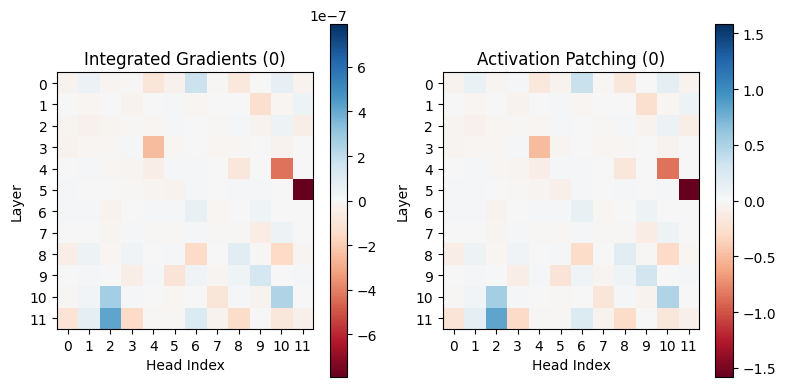

In [10]:
from utils import plot_attn_comparison

plot_attn_comparison(ioi_ig_attn[0].unsqueeze(0), ioi_ap_attn[0].unsqueeze(0), Task.IOI, model)

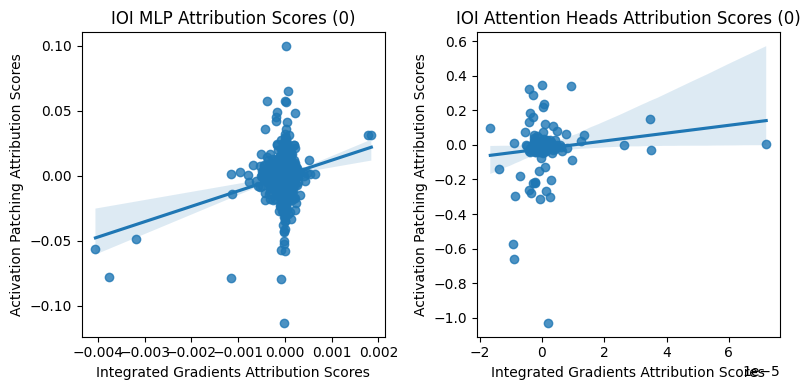

Correlation coefficient for neurons: 0.17810261438023522
Correlation coefficient for attention heads: 0.12710344871337403


In [15]:
mean_ioi_ig_zero_mlp = ioi_ig_mlp.mean(dim=0, keepdim=True)
mean_ioi_ap_mlp = ioi_ap_mlp.mean(dim=0, keepdim=True)
mean_ioi_ig_zero_attn = ioi_ig_zero_attn.mean(dim=0, keepdim=True)
mean_ioi_ap_attn = ioi_ap_attn.mean(dim=0, keepdim=True)

plot_correlation(mean_ioi_ig_zero_mlp, mean_ioi_ap_mlp, mean_ioi_ig_zero_attn, mean_ioi_ap_attn, Task.IOI)

# plot_correlation(ioi_ig_zero_mlp, ioi_ap_mlp, ioi_ig_zero_attn, ioi_ap_attn, Task.IOI)

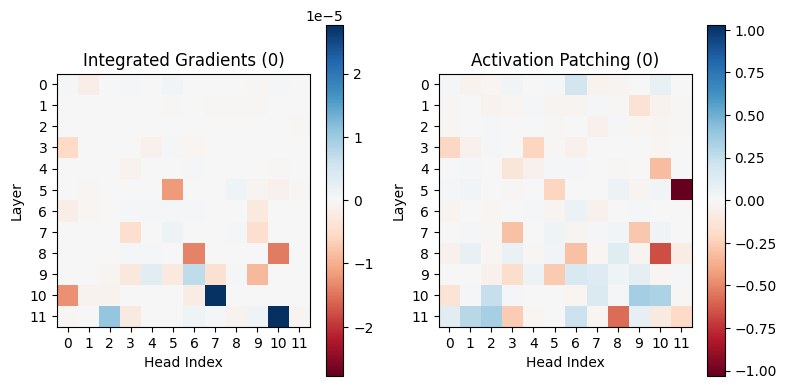

In [19]:
from utils import plot_attn_comparison

mean_ioi_ig_attn = ioi_ig_attn.mean(dim=0, keepdim=True)

plot_attn_comparison(mean_ioi_ig_attn, mean_ioi_ap_attn, Task.IOI, model)

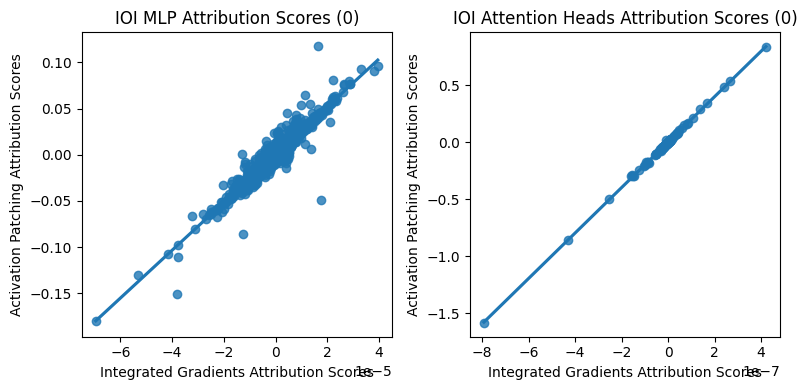

Correlation coefficient for neurons: 0.9781080432379063
Correlation coefficient for attention heads: 0.9996766516207032


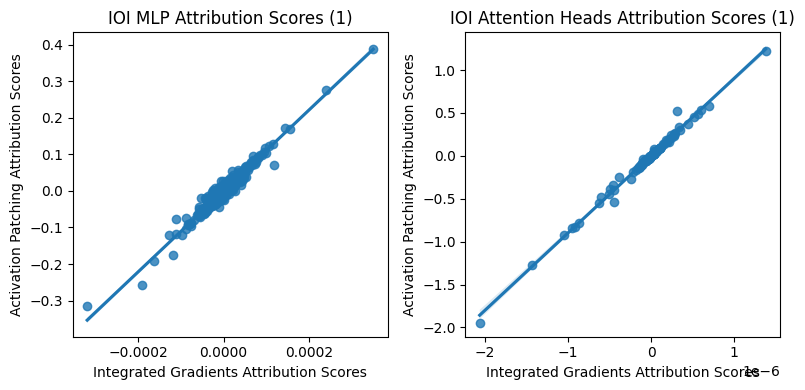

Correlation coefficient for neurons: 0.9806869213056343
Correlation coefficient for attention heads: 0.9951896346601156


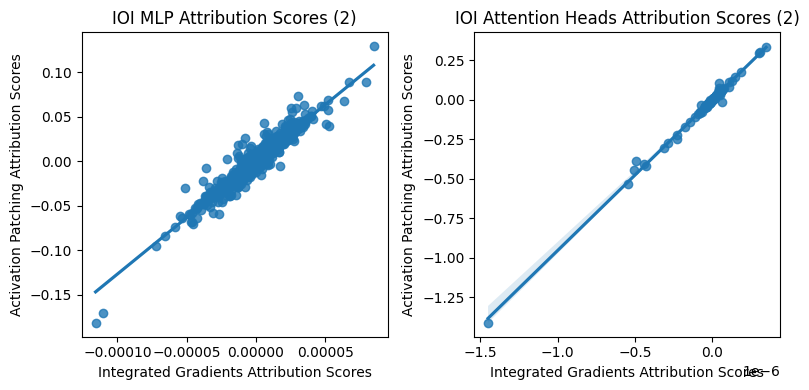

Correlation coefficient for neurons: 0.9757320351325801
Correlation coefficient for attention heads: 0.9967339347971004


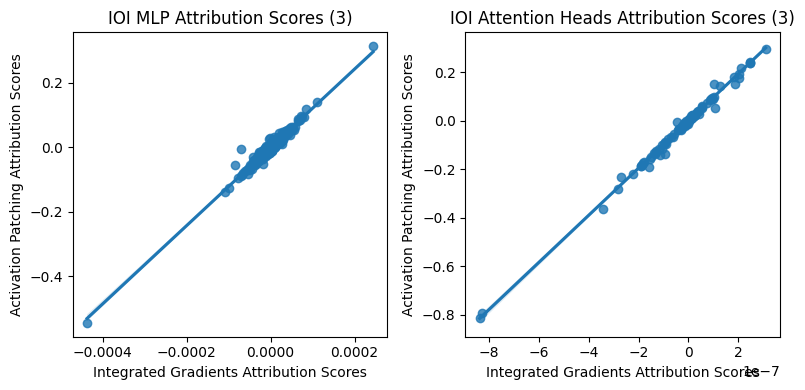

Correlation coefficient for neurons: 0.9839111524360439
Correlation coefficient for attention heads: 0.996740309786814


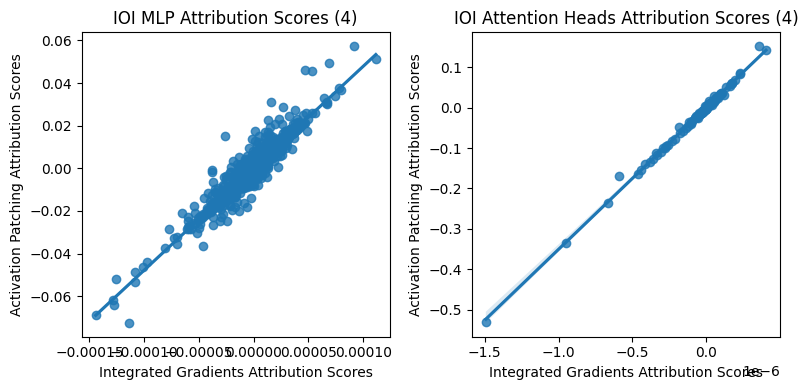

Correlation coefficient for neurons: 0.9670389804392867
Correlation coefficient for attention heads: 0.9977772050389823


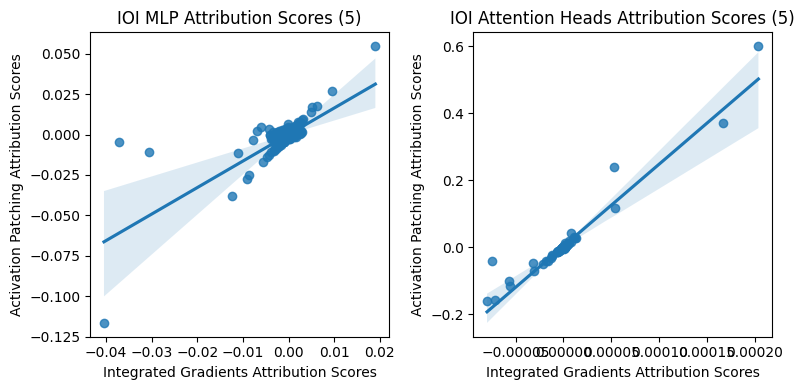

Correlation coefficient for neurons: 0.7595119716894685
Correlation coefficient for attention heads: 0.9632317618652253


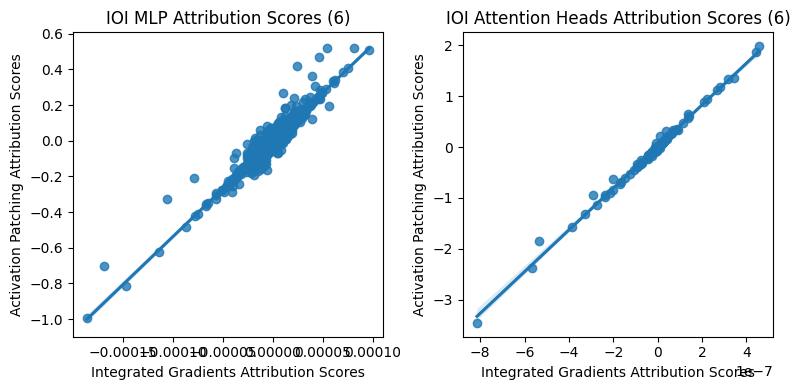

Correlation coefficient for neurons: 0.9741439049868224
Correlation coefficient for attention heads: 0.9965606146410044


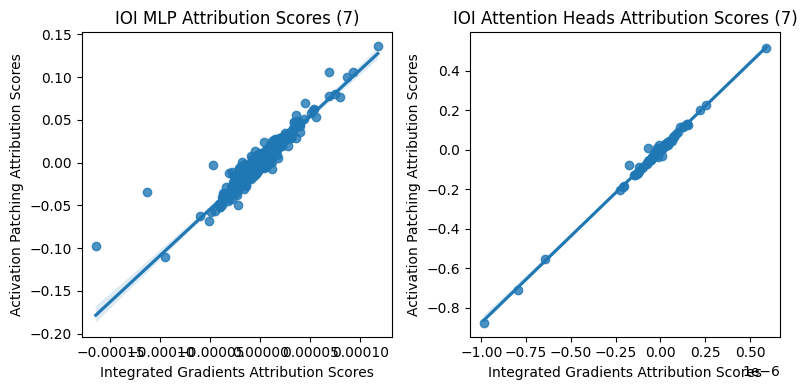

Correlation coefficient for neurons: 0.9665006578516521
Correlation coefficient for attention heads: 0.9964217666046798


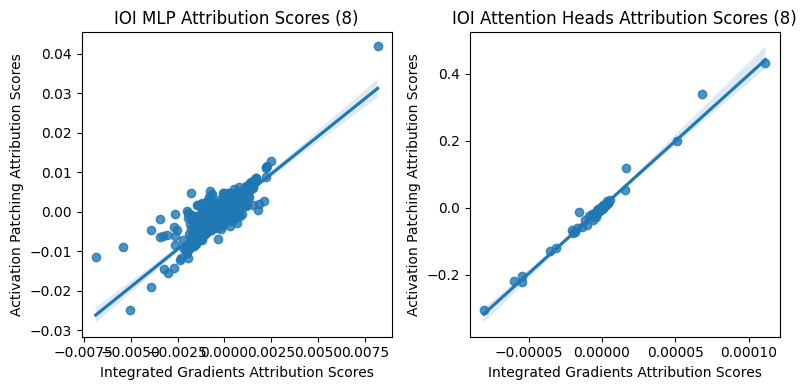

Correlation coefficient for neurons: 0.8802485907793042
Correlation coefficient for attention heads: 0.9904691632403823


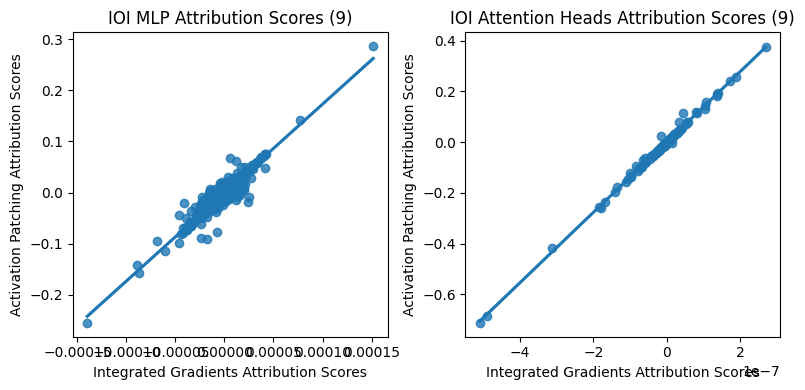

Correlation coefficient for neurons: 0.9687053829055899
Correlation coefficient for attention heads: 0.9978241411386138


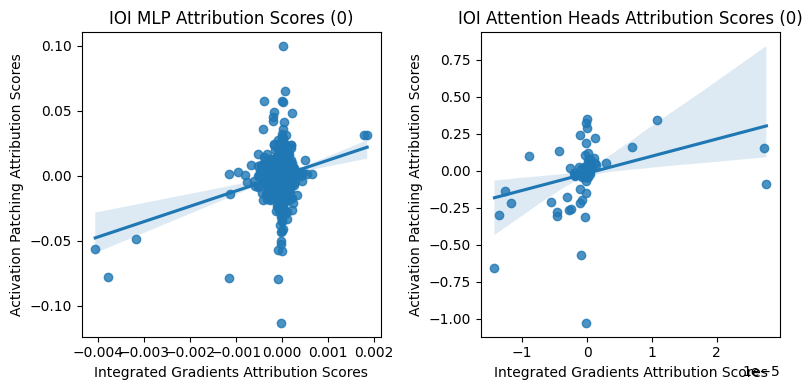

Correlation coefficient for neurons: 0.17810261438023522
Correlation coefficient for attention heads: 0.32514318518510626


In [20]:
mean_ioi_ig_mlp = ioi_ig_mlp.mean(dim=0, keepdim=True)

plot_correlation(ioi_ig_mlp, ioi_ap_mlp, ioi_ig_attn, ioi_ap_attn, Task.IOI)
plot_correlation(mean_ioi_ig_mlp, mean_ioi_ap_mlp, mean_ioi_ig_attn, mean_ioi_ap_attn, Task.IOI)

# Task 2: Gender Bias

In [124]:
gender_bias_dataset = TaskDataset(Task.GENDER_BIAS)
gender_bias_dataloader = gender_bias_dataset.to_dataloader(batch_size=10)

In [125]:
clean_input, corrupted_input, labels = next(iter(gender_bias_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.4348, -1.5338,  1.4572,  1.4659,  1.4542,  1.3636,  1.4376,  1.5102,
        -1.4453,  0.6453], device='cuda:0')
Corrupted logit difference: tensor([-3.9465, -1.5776,  1.1531,  1.2531,  1.2493, -4.2106,  1.3220,  1.3344,
        -1.5273, -4.0531], device='cuda:0')


In [126]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

gender_bias_ig_zero_mlp, gender_bias_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_zero_mlp, "saved_results/gender_bias_ig_zero_mlp.pt")
torch.save(gender_bias_ig_zero_attn, "saved_results/gender_bias_ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 1.0618,  0.0700, -0.1335,  0.0281,  0.0362, -1.1826, -0.0740,  0.0765,
        -0.0573,  2.3848], device='cuda:0')
torch.Size([10, 6, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-0.1576, -0.1701,  0.2202,  0.2713,  0.1570, -0.0282,  0.0766,  0.0926,
        -0.1772, -0.0250], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-5.5581e-06, -1.4044e-06, -2.2594e-06,  8.0094e-07, -7.7486e-07,
        -2.3335e-05,  1.0058e-06, -6.5379e-07,  2.3460e-06,  4.4703e-07],
       device='cuda:0')
torch.Size([10, 6, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-1.6049e-05, -2.6822e-07,  3.7253e-07, -7.8976e-07, -6.5565e-07,
         8.4937e-06, -1.0133e-06,  7.5996e-07,  2.2650e-06,  1.1086e-05],
       device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([ 8.0466e-06, -1.7695e-06,  8.2701e-07,  1.3039e-07, -8.3819e

In [34]:
gender_bias_ig_mlp, gender_bias_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(gender_bias_ig_mlp, "saved_results/gender_bias_ig_mlp.pt")
torch.save(gender_bias_ig_attn, "saved_results/gender_bias_ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 1.0222e-05, -5.9698e-07, -2.4214e-08, -4.6194e-07, -2.3842e-07,
        -9.1791e-06, -8.6706e-07, -1.2852e-07,  0.0000e+00, -2.8610e-06],
       device='cuda:0')
torch.Size([10, 6, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([ 0.0000e+00, -4.4703e-07, -6.5565e-07, -5.3644e-07, -2.6822e-07,
        -2.5272e-05, -3.5763e-07,  1.6391e-07, -3.7253e-07,  0.0000e+00],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 1.4469e-05, -1.1735e-07, -1.6410e-06,  1.0440e-06, -1.2955e-06,
        -3.4198e-05,  6.5006e-07,  4.6194e-07,  1.2442e-06, -5.6364e-06],
       device='cuda:0')
torch.Size([10, 6, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-9.3877e-06, -1.4482e-07, -1.6391e-07, -5.1036e-07, -5.7556e-07,
        -5.7369e-06,  5.8394e-07,  7.5623e-07,  1.7835e-06,  1.0878e-05],
       device='cuda:0')

Error (delta) for blocks.2.attn

In [ ]:
gender_bias_ap_mlp, gender_bias_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(gender_bias_ap_mlp, "saved_results/gender_bias_ap_mlp.pt")
torch.save(gender_bias_ap_attn, "saved_results/gender_bias_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0


In [104]:
gender_bias_ig_mlp = torch.load("saved_results/gender_bias_ig_mlp.pt")
gender_bias_ap_mlp = torch.load("saved_results/gender_bias_ap_mlp.pt")
gender_bias_ig_attn = torch.load("saved_results/gender_bias_ig_attn.pt")
gender_bias_ap_attn = torch.load("saved_results/gender_bias_ap_attn.pt")

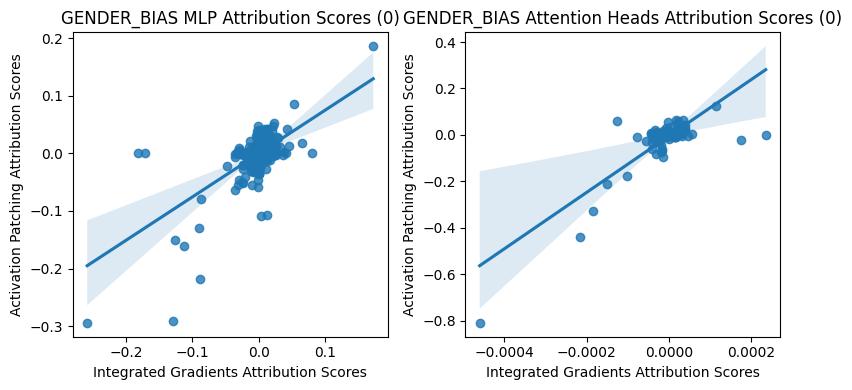

Correlation coefficient for neurons: 0.5947656884436068
Correlation coefficient for attention heads: 0.8118996367336919


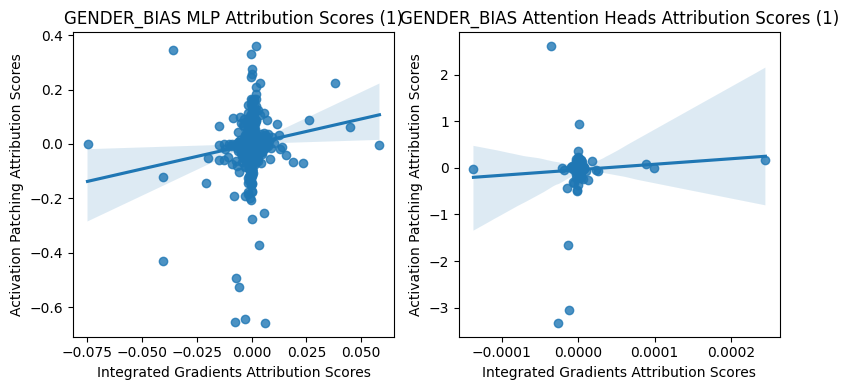

Correlation coefficient for neurons: 0.11655900509750655
Correlation coefficient for attention heads: 0.06618016530939137


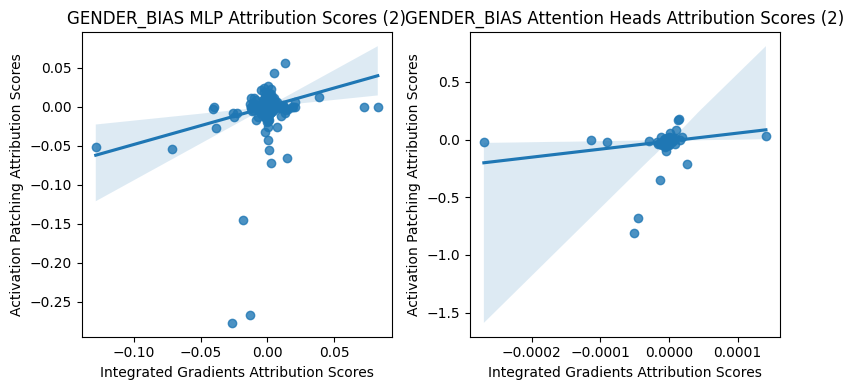

Correlation coefficient for neurons: 0.22675030114676095
Correlation coefficient for attention heads: 0.20681846959147773


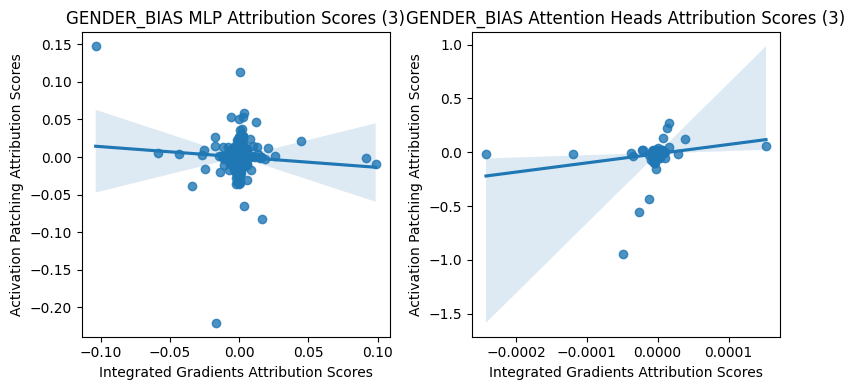

Correlation coefficient for neurons: -0.055709089614505755
Correlation coefficient for attention heads: 0.22068552528565746


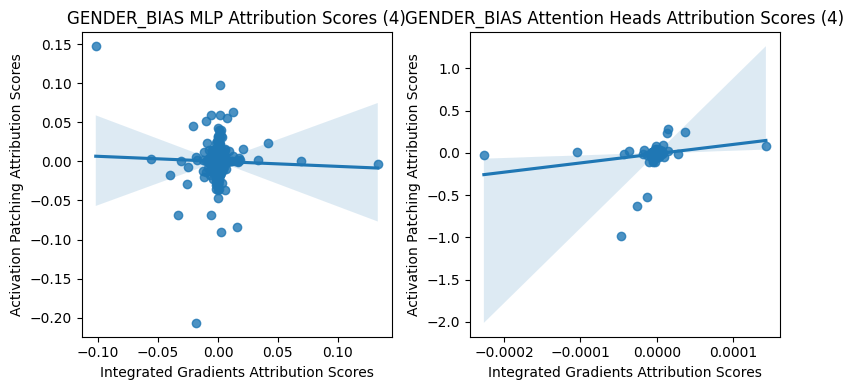

Correlation coefficient for neurons: -0.027434103721201624
Correlation coefficient for attention heads: 0.24125789635015346


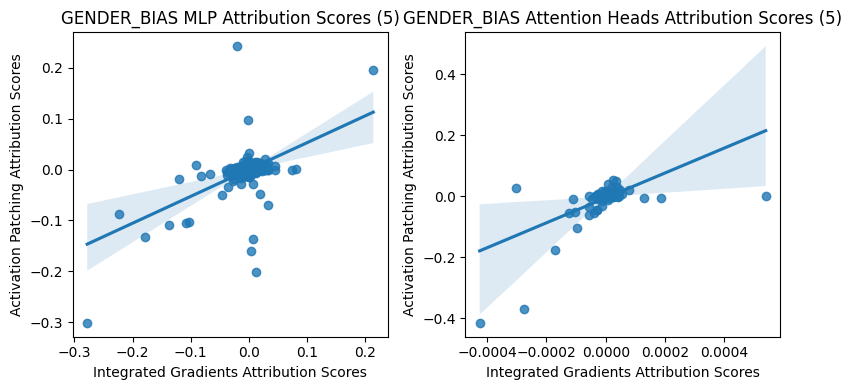

Correlation coefficient for neurons: 0.5454535152521637
Correlation coefficient for attention heads: 0.6059456490546115


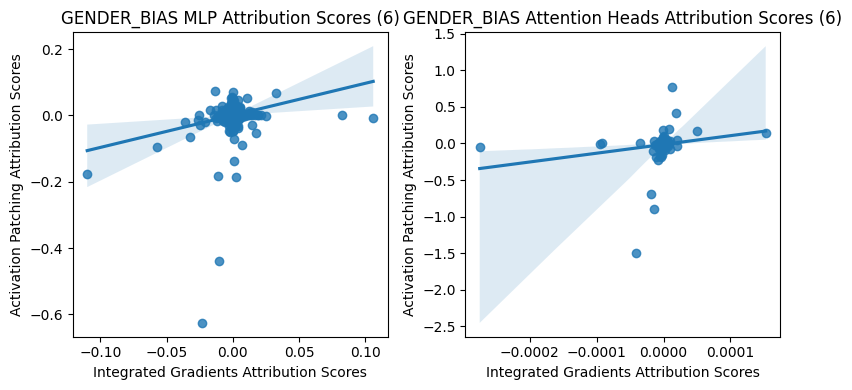

Correlation coefficient for neurons: 0.21534072884557562
Correlation coefficient for attention heads: 0.1957546812241763


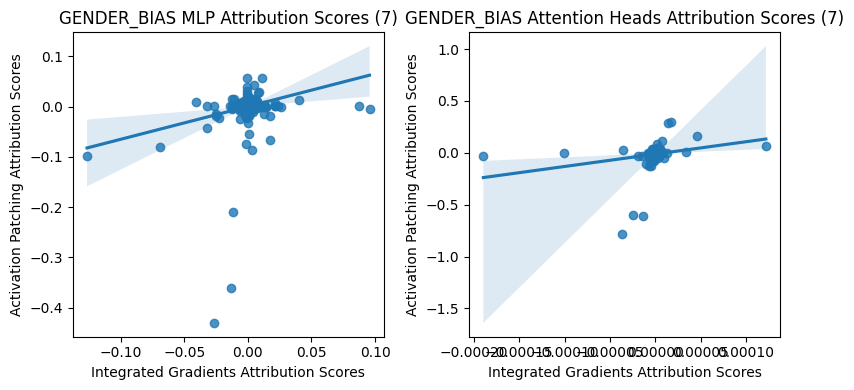

Correlation coefficient for neurons: 0.2307057756722892
Correlation coefficient for attention heads: 0.2467289114769223


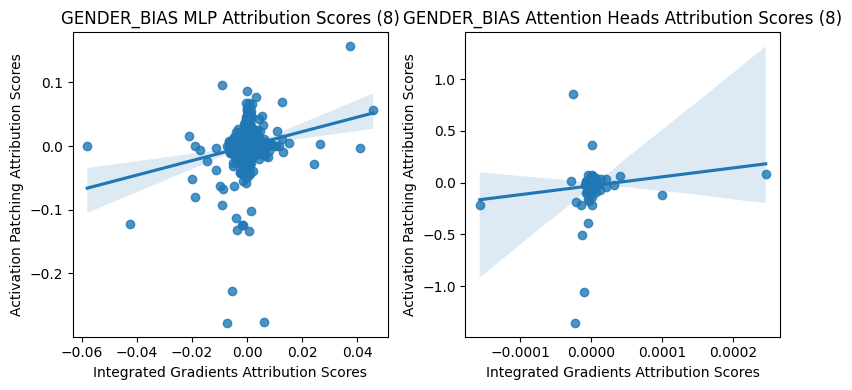

Correlation coefficient for neurons: 0.17318297664720983
Correlation coefficient for attention heads: 0.12985969121133725


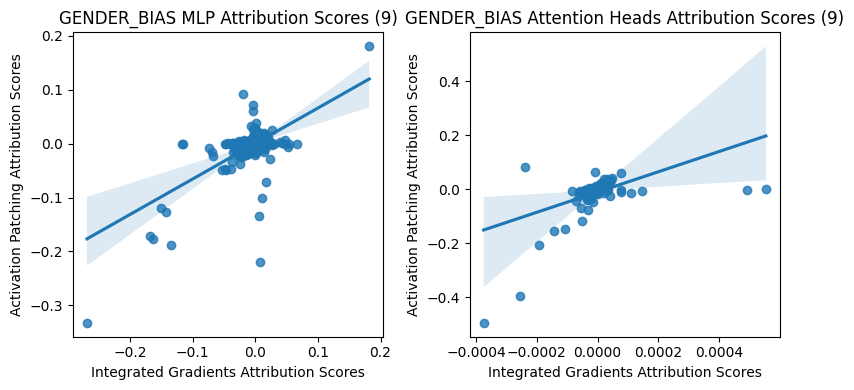

Correlation coefficient for neurons: 0.6310614011727056
Correlation coefficient for attention heads: 0.512772389002063


In [127]:
plot_correlation(gender_bias_ig_zero_mlp, gender_bias_ap_mlp, gender_bias_ig_zero_attn, gender_bias_ap_attn, Task.GENDER_BIAS)

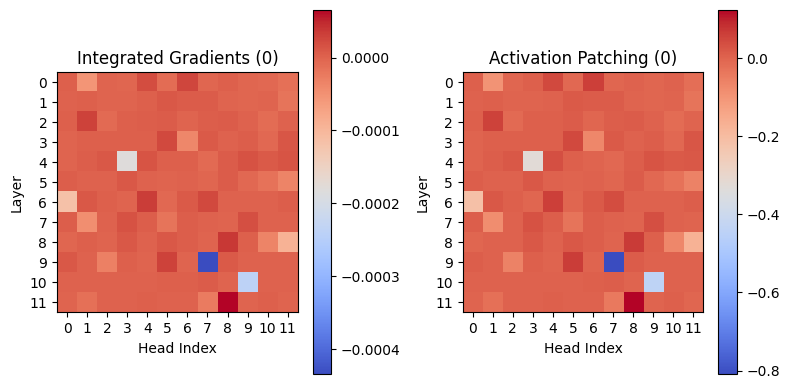

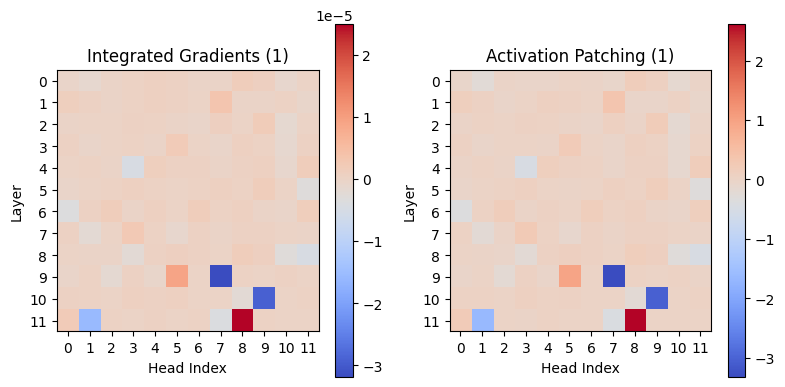

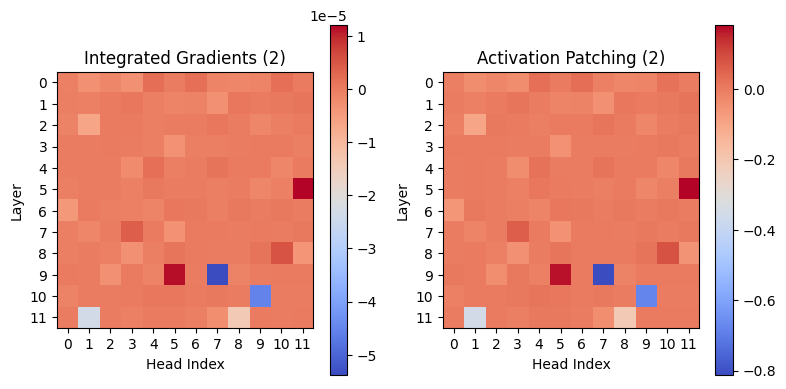

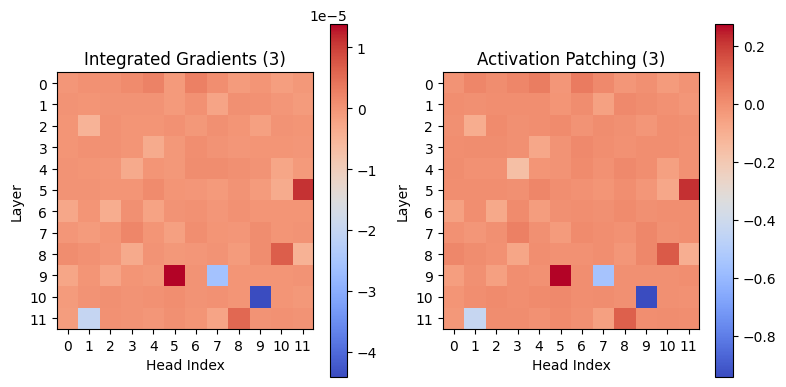

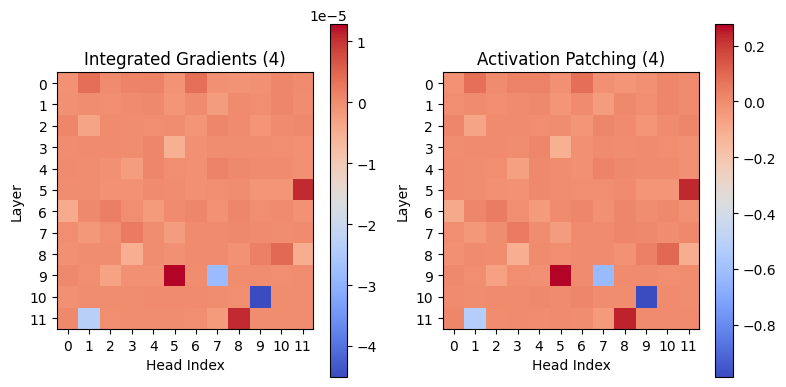

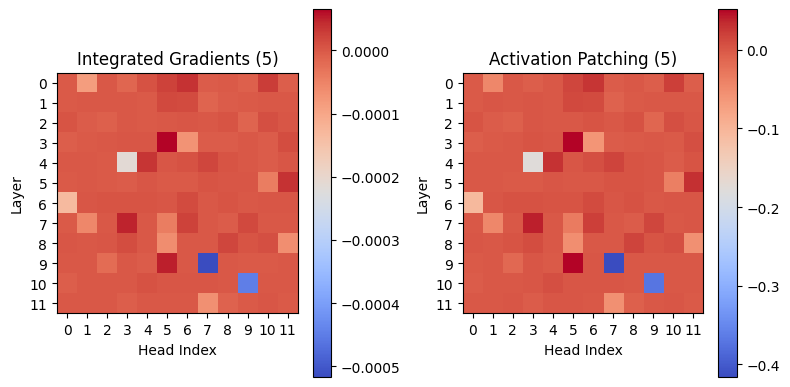

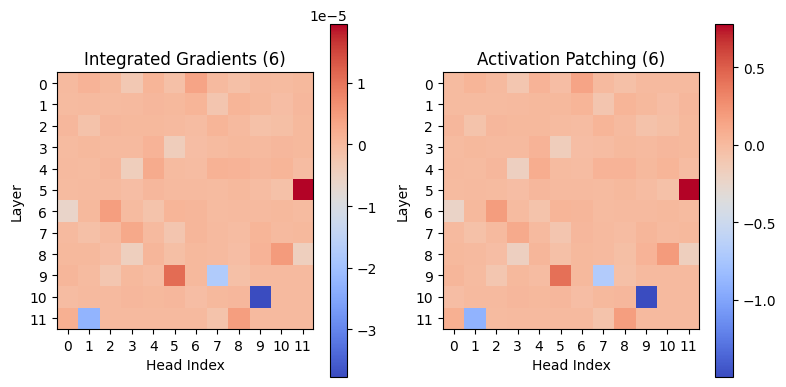

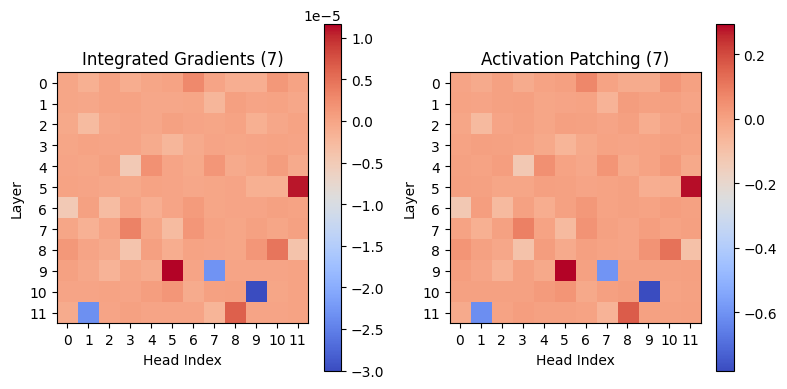

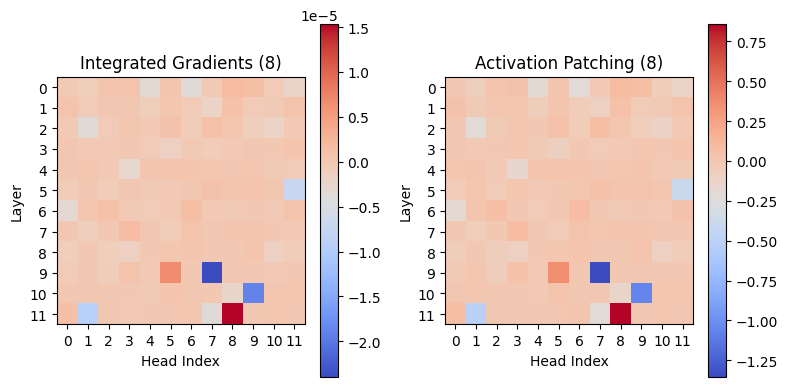

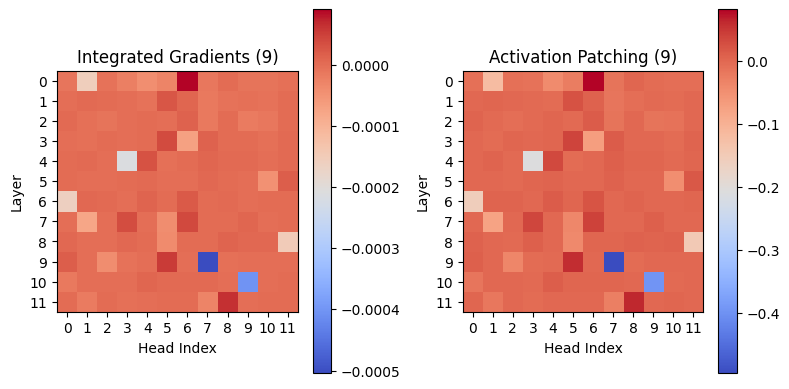

In [105]:
plot_attn_comparison(gender_bias_ig_attn, gender_bias_ap_attn, Task.GENDER_BIAS)

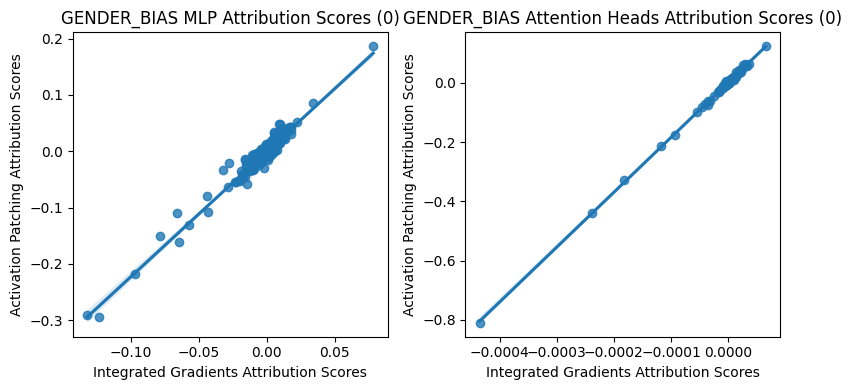

Correlation coefficient for neurons: 0.9753828882991221
Correlation coefficient for attention heads: 0.999443438810531


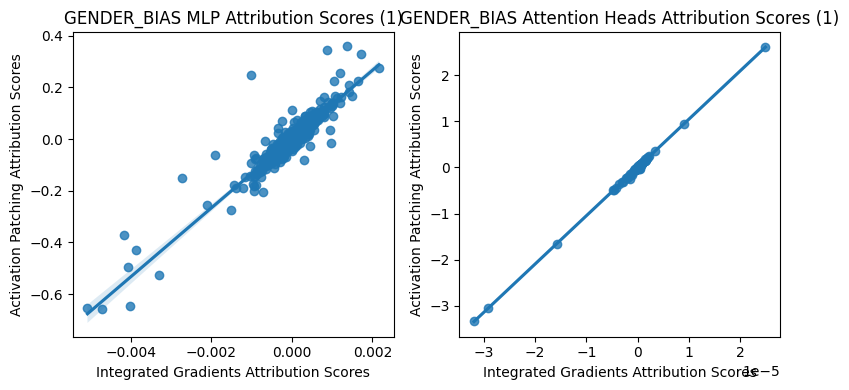

Correlation coefficient for neurons: 0.9428177907538642
Correlation coefficient for attention heads: 0.9994535506491192


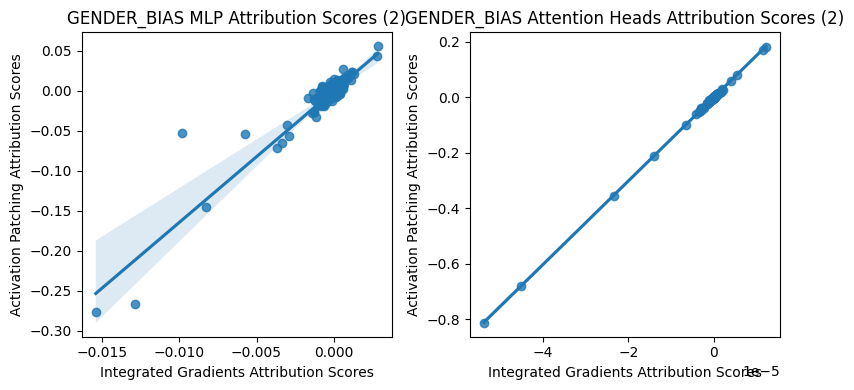

Correlation coefficient for neurons: 0.939412560070206
Correlation coefficient for attention heads: 0.9998399010519584


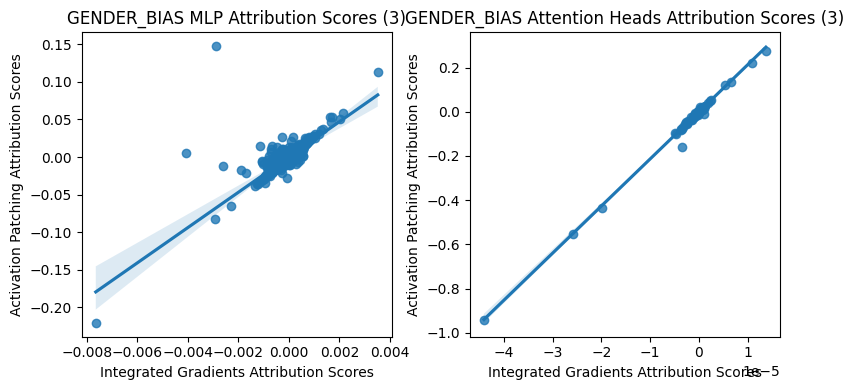

Correlation coefficient for neurons: 0.8452039674890598
Correlation coefficient for attention heads: 0.996724637686606


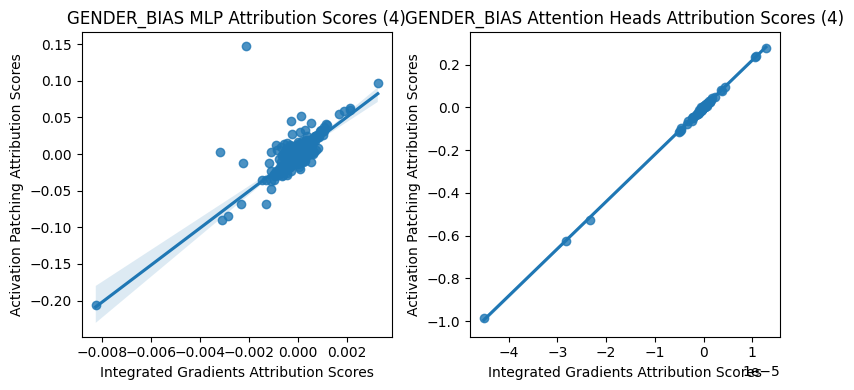

Correlation coefficient for neurons: 0.8369763451019916
Correlation coefficient for attention heads: 0.9997368020655754


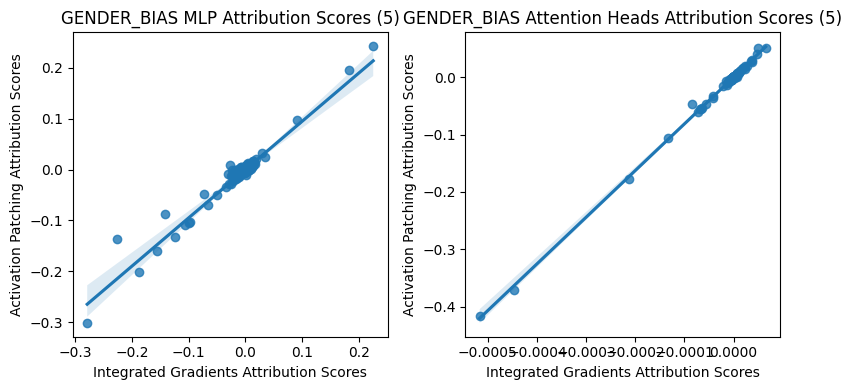

Correlation coefficient for neurons: 0.9715653915378282
Correlation coefficient for attention heads: 0.9988334963320437


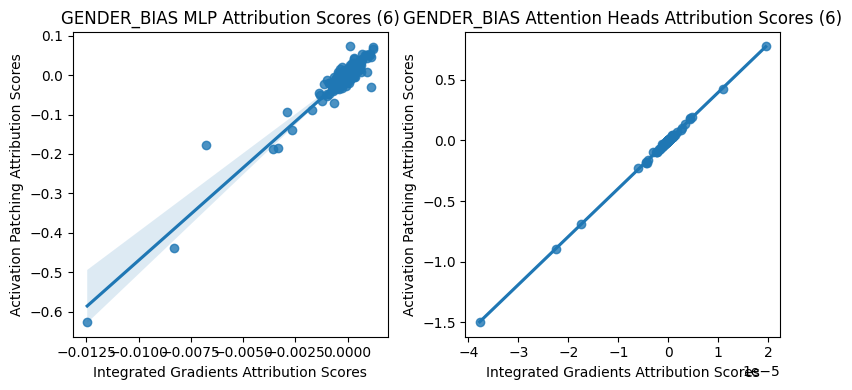

Correlation coefficient for neurons: 0.9563566703664143
Correlation coefficient for attention heads: 0.9997594594599919


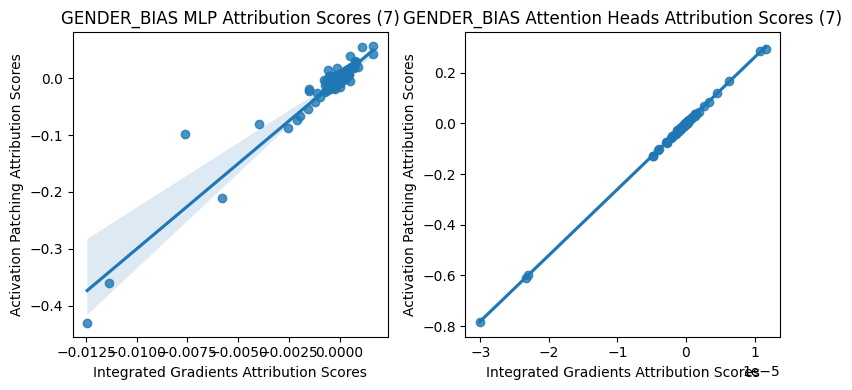

Correlation coefficient for neurons: 0.9603318274839185
Correlation coefficient for attention heads: 0.9998917388388492


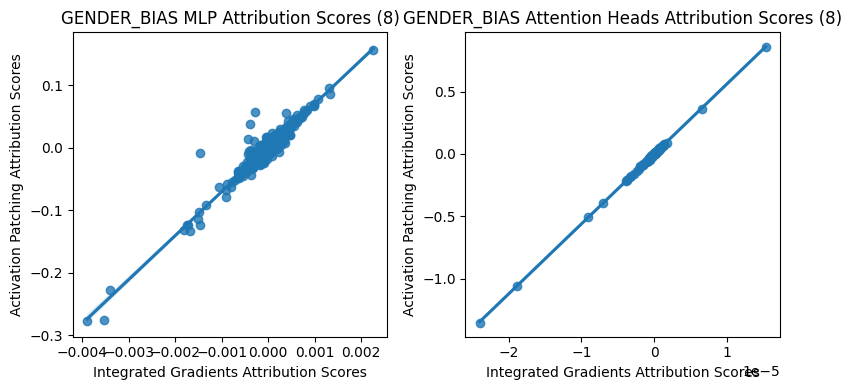

Correlation coefficient for neurons: 0.9706784300664033
Correlation coefficient for attention heads: 0.9998341557351473


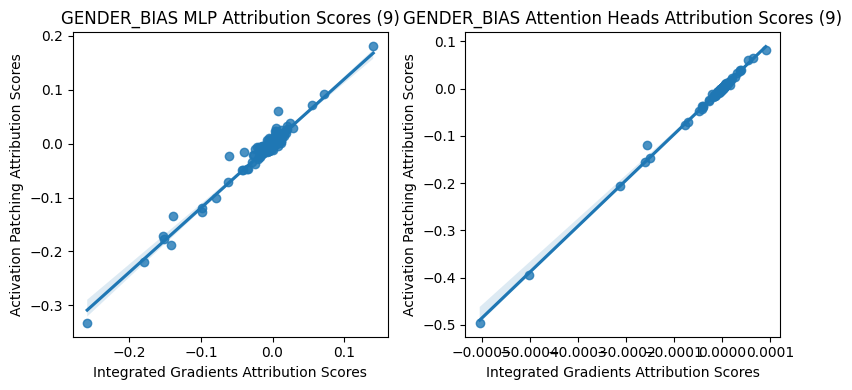

Correlation coefficient for neurons: 0.9771437807459755
Correlation coefficient for attention heads: 0.9986269454313028


In [106]:
plot_correlation(gender_bias_ig_mlp, gender_bias_ap_mlp, gender_bias_ig_attn, gender_bias_ap_attn, Task.GENDER_BIAS)

# Task 3: Greater Than

In [128]:
greater_than_dataset = TaskDataset(Task.GREATER_THAN)
greater_than_dataloader = greater_than_dataset.to_dataloader(batch_size=10)

In [129]:
def greater_than_prob_diff_metric(logits, correct_years):
    batch_size = logits.size(0)
    year_indices = model.to_tokens([f"{year:02d}" for year in range(100)])[:, 1] # Shape [100]
    logits_last = logits[:, -1, :]
    logit_probs = torch.softmax(logits_last, dim=-1) # Shape [batch, d_vocab]
    year_probs = logit_probs[:, year_indices] # Shape [batch, 100]
    
    results = torch.zeros((batch_size))
    for i, (probs, year) in enumerate(zip(year_probs, correct_years)):
        results[i] = probs[year+1:].sum() - probs[:year+1].sum()
    
    results = results.to(logits.device)
    return results

In [130]:
clean_input, corrupted_input, labels = next(iter(greater_than_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)
labels = labels.to(clean_tokens.device)

print(clean_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = greater_than_prob_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = greater_than_prob_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

['The contract lasted from the year 1352 to the year 13', 'The plan lasted from the year 1642 to the year 16', 'The plan lasted from the year 1457 to the year 14', 'The marriage lasted from the year 1783 to the year 17', 'The campaign lasted from the year 1388 to the year 13', 'The progress lasted from the year 1491 to the year 14', 'The study lasted from the year 1727 to the year 17', 'The case lasted from the year 1655 to the year 16', 'The fall lasted from the year 1375 to the year 13', 'The progress lasted from the year 1535 to the year 15']
Clean logit difference: tensor([0.8670, 0.8998, 0.9045, 0.8931, 0.8261, 0.8083, 0.9399, 0.8767, 0.7247,
        0.9015], device='cuda:0')
Corrupted logit difference: tensor([-0.6238, -0.7374, -0.7662, -0.8959, -0.9398, -0.9631, -0.1313, -0.7899,
        -0.8827, -0.5026], device='cuda:0')


In [131]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

greater_than_ig_zero_mlp, greater_than_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, corrupted_cache, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ig_zero_mlp, "saved_results/greater_than_ig_zero_mlp.pt")
torch.save(greater_than_ig_zero_attn, "saved_results/greater_than_ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 0.3799, -0.2619,  1.2151, -0.4563, -0.9089, -0.7103, -0.6796, -0.2921,
         0.7564,  0.0056], device='cuda:0')
torch.Size([10, 13, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-0.0678,  0.0026, -0.0196, -0.0171, -0.0171,  0.0110,  0.0164, -0.0006,
         0.0008, -0.0064], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-4.7125e-07, -1.8626e-08,  9.3132e-10, -3.1525e-07, -1.4082e-06,
        -2.4587e-07,  2.9057e-07,  3.5018e-07,  7.8231e-08, -4.4517e-07],
       device='cuda:0')
torch.Size([10, 13, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([ 8.6054e-07,  4.4703e-07,  3.5390e-08,  1.1791e-06, -1.4901e-08,
        -6.2585e-07, -2.8685e-07,  4.9174e-07,  2.9802e-08, -8.9779e-07],
       device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([-3.1292e-07,  1.4901e-07, -2.7567e-07,  1.6391e-07, -1.877

In [44]:
greater_than_ig_mlp, greater_than_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, greater_than_prob_diff_metric, labels)

torch.save(greater_than_ig_mlp, "saved_results/greater_than_ig_mlp.pt")
torch.save(greater_than_ig_attn, "saved_results/greater_than_ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 6.7800e-07,  7.0035e-07,  1.0580e-06, -2.3842e-07,  2.2352e-07,
        -7.3016e-07, -1.7509e-07, -5.9605e-07,  9.0897e-07,  9.3877e-07],
       device='cuda:0')
torch.Size([10, 13, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([-1.5497e-06,  1.7881e-06,  1.7881e-06,  2.5034e-06,  8.3447e-07,
        -2.3842e-06, -7.1526e-07,  2.0266e-06,  3.5763e-07,  1.7881e-06],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([-2.5379e-07,  1.7933e-06, -4.8894e-07, -1.3378e-06, -8.8848e-07,
        -9.7556e-07, -8.5565e-08, -1.1083e-07,  2.5984e-07, -2.8545e-07],
       device='cuda:0')
torch.Size([10, 13, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([-2.6450e-07,  8.3819e-07,  2.8685e-07, -2.0489e-07, -8.4192e-07,
        -3.9637e-06, -4.3213e-07,  4.0978e-07, -2.3097e-07,  4.4703e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [46]:
greater_than_ap_mlp, greater_than_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    greater_than_prob_diff_metric, labels)

torch.save(greater_than_ap_mlp, "saved_results/greater_than_ap_mlp.pt")
torch.save(greater_than_ap_attn, "saved_results/greater_than_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [132]:
greater_than_ig_mlp = torch.load("saved_results/greater_than_ig_mlp.pt")
greater_than_ap_mlp = torch.load("saved_results/greater_than_ap_mlp.pt")
greater_than_ig_attn = torch.load("saved_results/greater_than_ig_attn.pt")
greater_than_ap_attn = torch.load("saved_results/greater_than_ap_attn.pt")

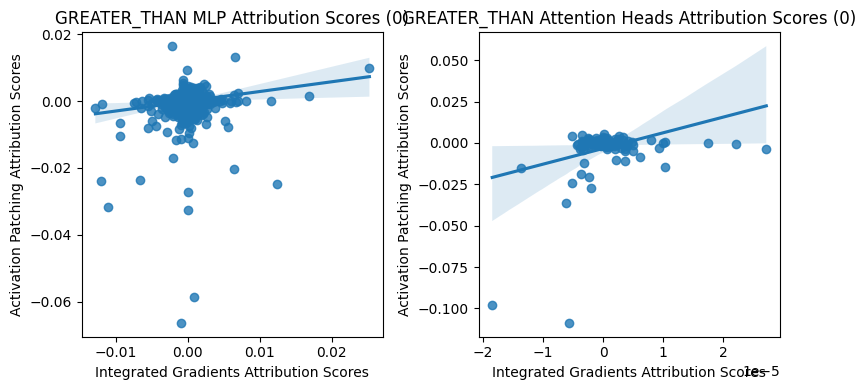

Correlation coefficient for neurons: 0.14970842604668944
Correlation coefficient for attention heads: 0.3366025550889032


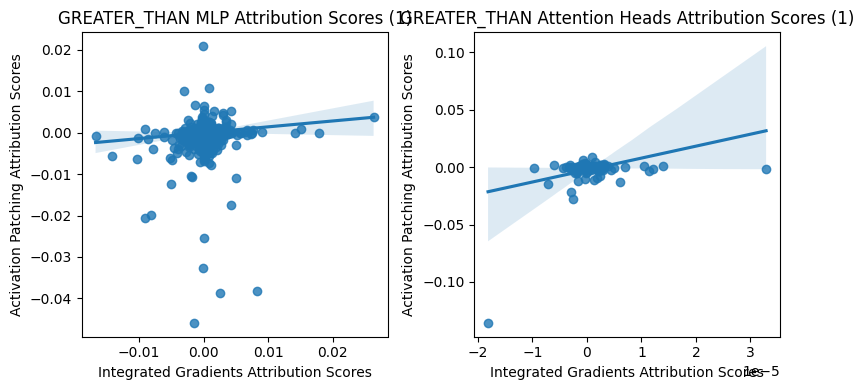

Correlation coefficient for neurons: 0.09409043317707765
Correlation coefficient for attention heads: 0.3713979578369161


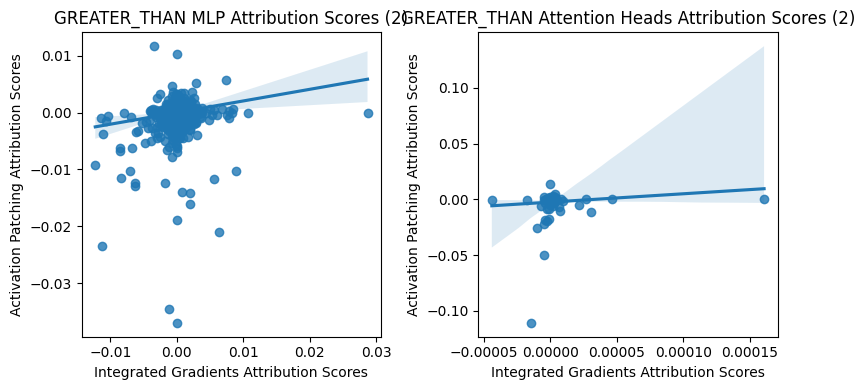

Correlation coefficient for neurons: 0.15418797493509134
Correlation coefficient for attention heads: 0.1041201753372195


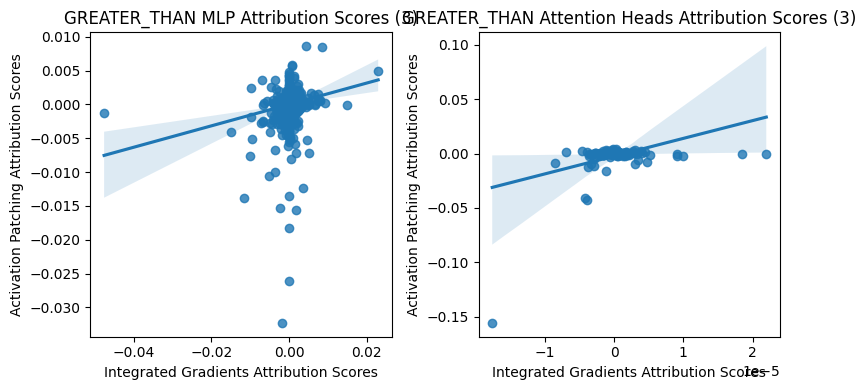

Correlation coefficient for neurons: 0.16651273383840895
Correlation coefficient for attention heads: 0.431416756083687


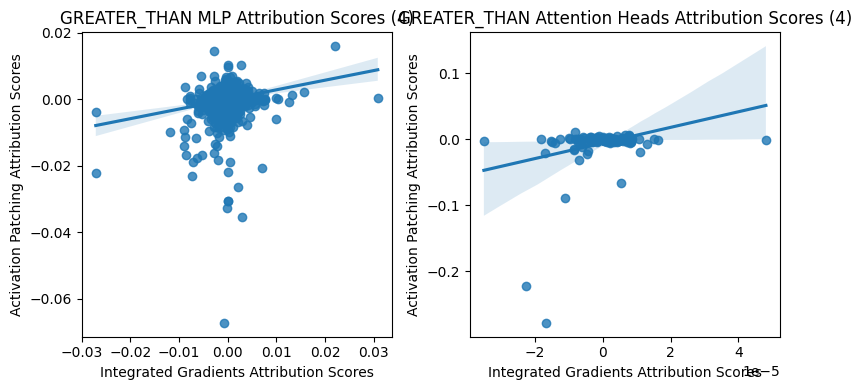

Correlation coefficient for neurons: 0.18933947085750036
Correlation coefficient for attention heads: 0.30464830594691633


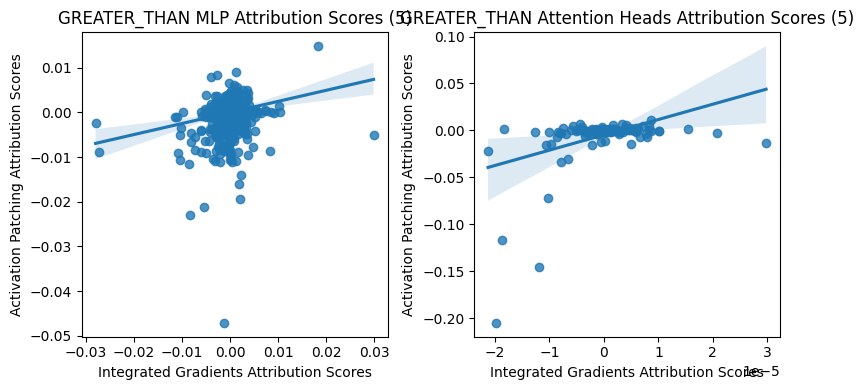

Correlation coefficient for neurons: 0.19409356738365832
Correlation coefficient for attention heads: 0.4335232759214915


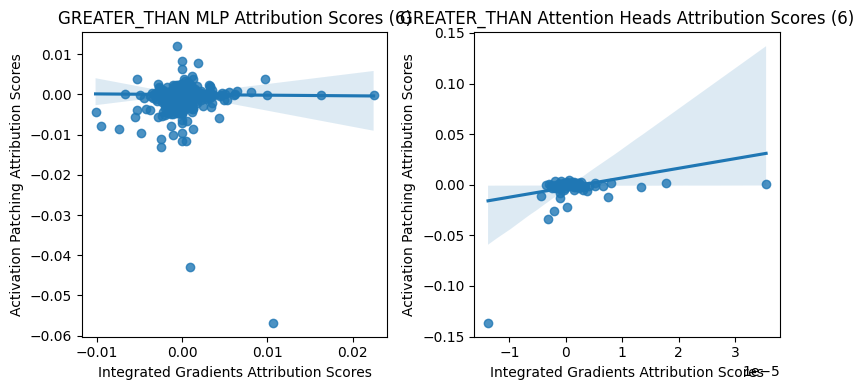

Correlation coefficient for neurons: -0.009569714734432517
Correlation coefficient for attention heads: 0.3166847611058171


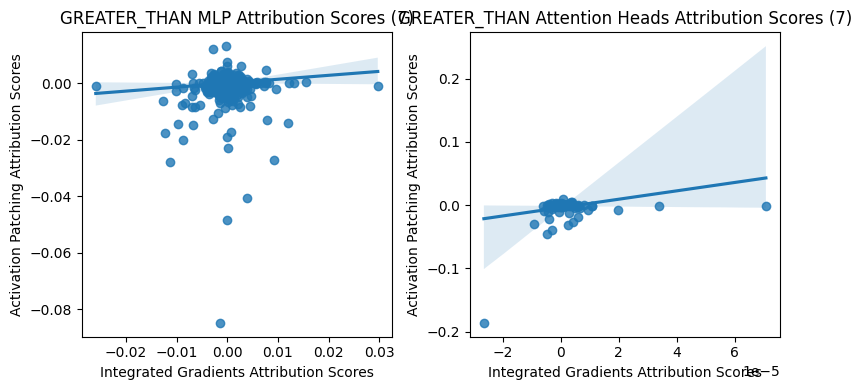

Correlation coefficient for neurons: 0.08432841632348097
Correlation coefficient for attention heads: 0.2972654469432707


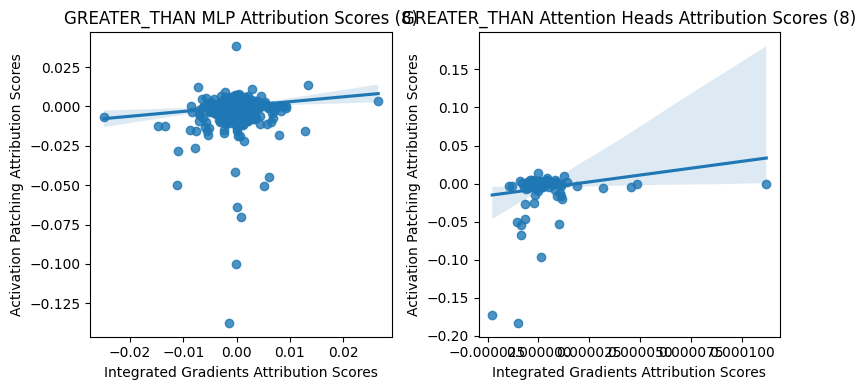

Correlation coefficient for neurons: 0.10628191929216035
Correlation coefficient for attention heads: 0.18092160812445243


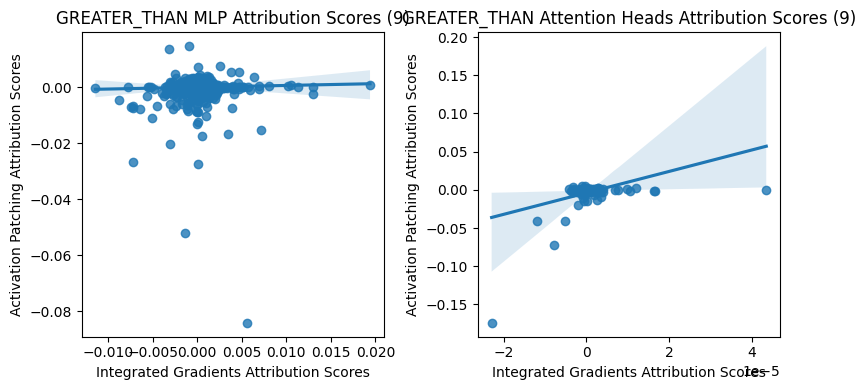

Correlation coefficient for neurons: 0.03174842857332431
Correlation coefficient for attention heads: 0.44334238281899463


In [133]:
plot_correlation(greater_than_ig_zero_mlp, greater_than_ap_mlp, greater_than_ig_zero_attn, greater_than_ap_attn, Task.GREATER_THAN)

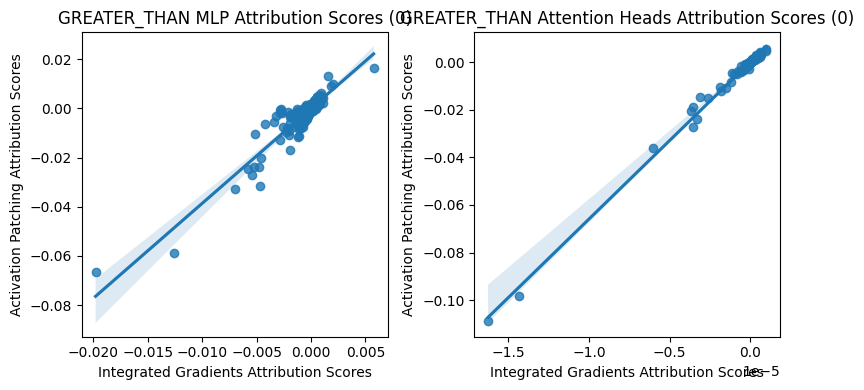

Correlation coefficient for neurons: 0.9221134366688722
Correlation coefficient for attention heads: 0.9965490130314649


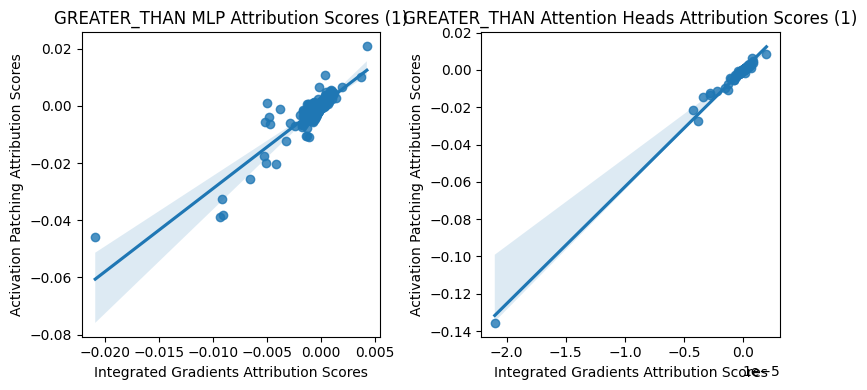

Correlation coefficient for neurons: 0.8871170520998003
Correlation coefficient for attention heads: 0.994403371200559


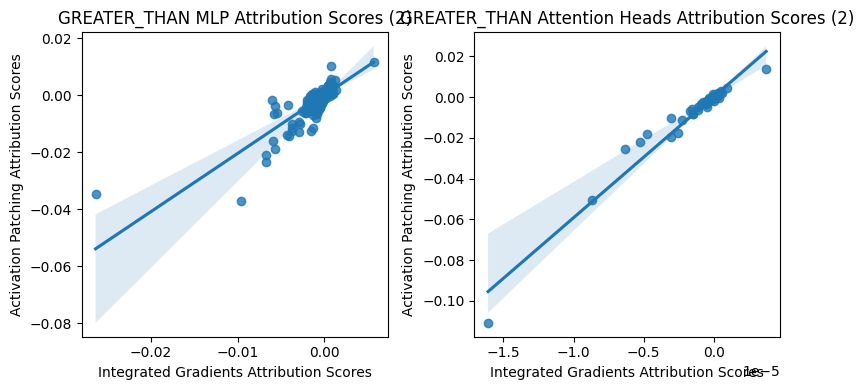

Correlation coefficient for neurons: 0.827849491683415
Correlation coefficient for attention heads: 0.9771730610065705


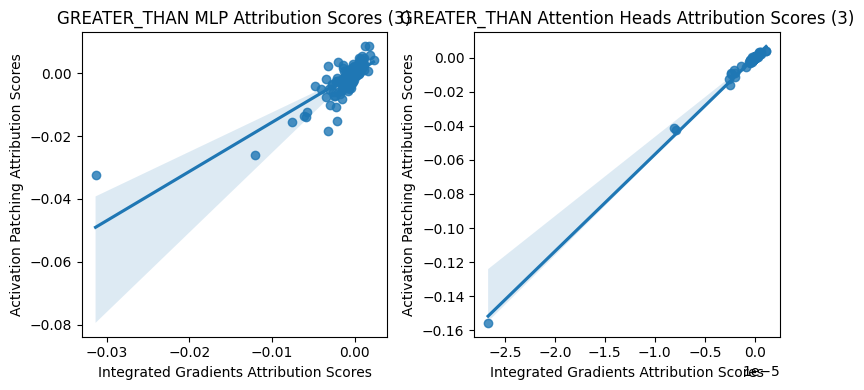

Correlation coefficient for neurons: 0.7898158611344127
Correlation coefficient for attention heads: 0.9973162137633402


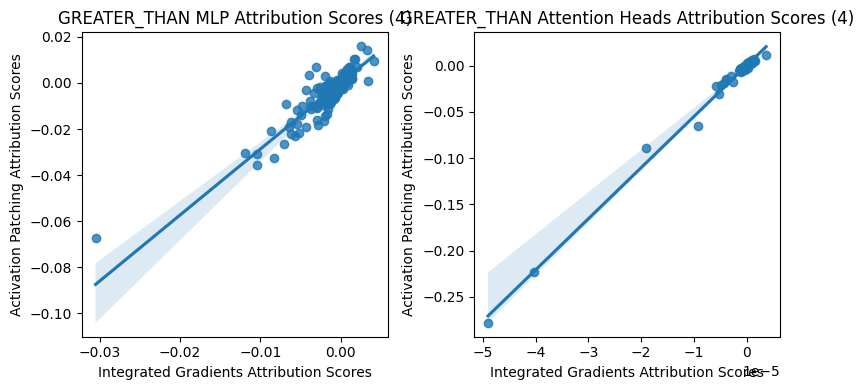

Correlation coefficient for neurons: 0.89470330596887
Correlation coefficient for attention heads: 0.9962798446193627


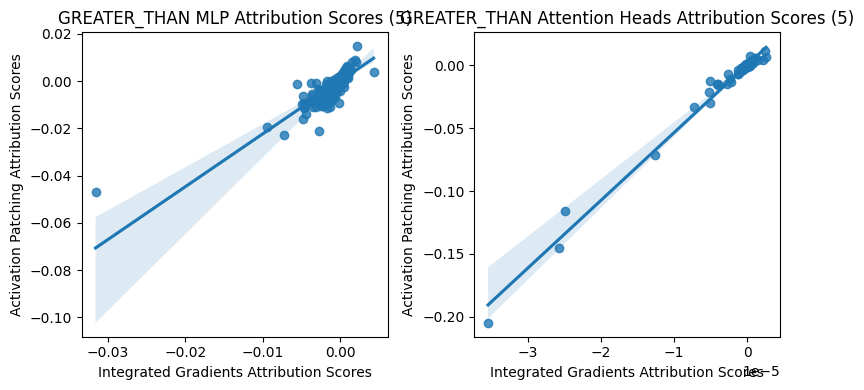

Correlation coefficient for neurons: 0.8296864131178074
Correlation coefficient for attention heads: 0.992265461721601


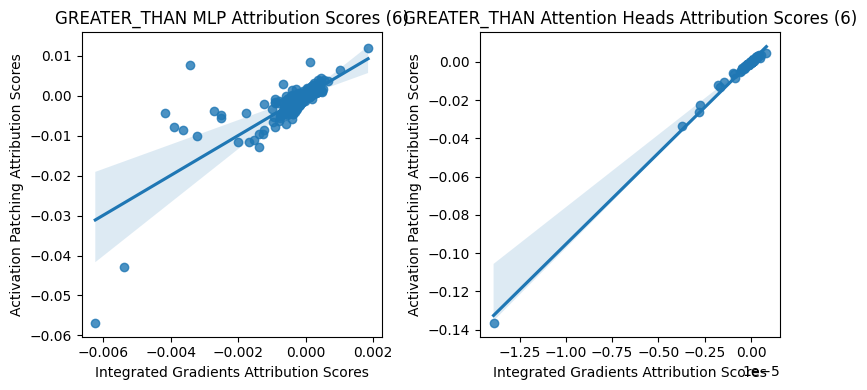

Correlation coefficient for neurons: 0.8026917941605797
Correlation coefficient for attention heads: 0.9968271123476021


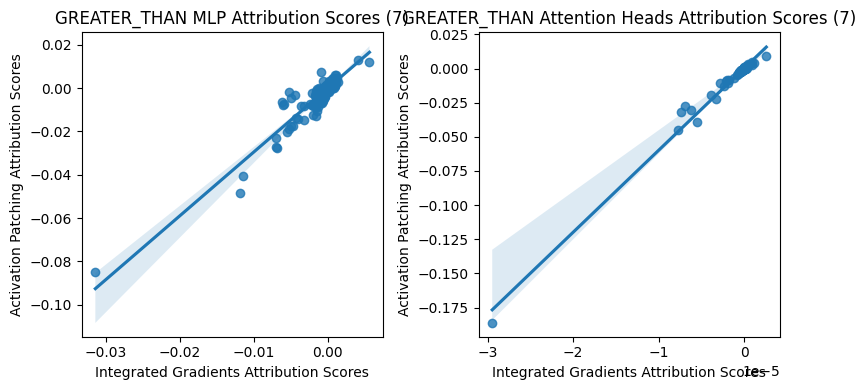

Correlation coefficient for neurons: 0.9285624323959478
Correlation coefficient for attention heads: 0.9913712645721706


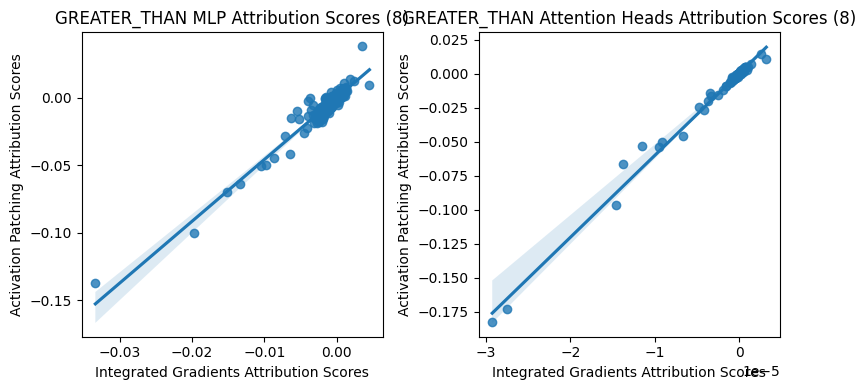

Correlation coefficient for neurons: 0.9588906529992473
Correlation coefficient for attention heads: 0.9946135435488325


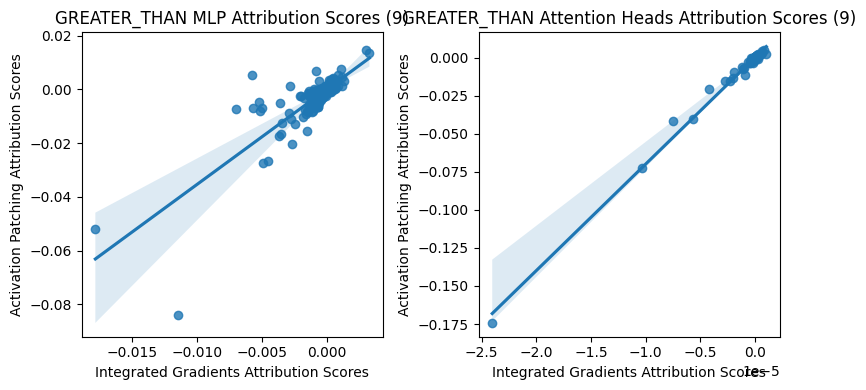

Correlation coefficient for neurons: 0.8240741254322812
Correlation coefficient for attention heads: 0.995304533049708


In [111]:
plot_correlation(greater_than_ig_mlp, greater_than_ap_mlp, greater_than_ig_attn, greater_than_ap_attn, Task.GREATER_THAN)

# Task 4: Capital Country

In [134]:
capital_country_dataset = TaskDataset(Task.CAPITAL_COUNTRY)
capital_country_dataloader = capital_country_dataset.to_dataloader(batch_size=10)

In [135]:
clean_input, corrupted_input, labels = next(iter(capital_country_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-1.8200, -2.5300, -2.0190,  6.3455, -0.5265,  0.9513,  0.8347, -1.4007,
         2.1496, -3.0366], device='cuda:0')
Corrupted logit difference: tensor([-1.8150, -2.5942, -2.0515,  0.9749, -0.7268,  0.7562,  0.4618, -1.4402,
         2.0016, -3.2090], device='cuda:0')


In [136]:
zero_baseline_cache_dict = dict()
for k, v in clean_cache.cache_dict.items():
    zero_baseline_cache_dict[k] = torch.zeros_like(v)
zero_baseline_cache = ActivationCache(zero_baseline_cache_dict, model)

capital_country_ig_zero_mlp, capital_country_ig_zero_attn = integrated_gradients(model, clean_tokens, zero_baseline_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_zero_mlp, "saved_results/capital_country_ig_zero_mlp.pt")
torch.save(capital_country_ig_zero_attn, "saved_results/capital_country_ig_zero_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([ 0.0318,  0.4031, -0.2706, -0.8905, -0.3926, -0.0277,  0.4741, -0.4776,
        -0.1170,  0.1728], device='cuda:0')
torch.Size([10, 11, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([ 0.0334,  0.0019, -0.0151,  0.3581,  0.1212,  0.4724, -0.0784,  0.4166,
        -0.0470, -0.0408], device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 1.2722e-06, -4.3586e-07, -1.4566e-06,  2.3842e-06,  6.7055e-08,
        -9.5926e-07, -9.0525e-07,  1.6205e-07, -3.3528e-08, -4.3362e-06],
       device='cuda:0')
torch.Size([10, 11, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([ 1.7881e-06, -1.5795e-06,  1.8775e-06,  4.7684e-06,  1.1362e-06,
        -5.2899e-07,  1.9521e-06, -2.5034e-06,  2.4736e-06, -2.5481e-06],
       device='cuda:0')

Error (delta) for blocks.2.attn.hook_result attribution: tensor([-2.2352e-07, -4.6939e-07, -8.9407e-08,  8.7023e-06,  6.016

In [49]:
capital_country_ig_mlp, capital_country_ig_attn = integrated_gradients(model, clean_tokens, clean_cache, corrupted_cache, logit_diff_metric, labels)

torch.save(capital_country_ig_mlp, "saved_results/capital_country_ig_mlp.pt")
torch.save(capital_country_ig_attn, "saved_results/capital_country_ig_attn.pt")


Error (delta) for blocks.0.attn.hook_result attribution: tensor([-9.8348e-07, -2.6673e-06, -5.6997e-07,  1.1325e-05,  2.4885e-06,
         1.1884e-06,  5.3830e-07,  1.6373e-06,  1.4678e-06,  6.7800e-07],
       device='cuda:0')
torch.Size([10, 11, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: tensor([ 8.7917e-07, -3.3900e-07, -4.8801e-06,  4.2915e-06,  1.1921e-07,
         7.0035e-07,  1.7881e-07,  1.5125e-06,  8.7917e-07, -2.9802e-08],
       device='cuda:0')

Error (delta) for blocks.1.attn.hook_result attribution: tensor([ 1.3672e-06,  7.3947e-07, -5.0701e-06,  3.7849e-06, -6.0722e-07,
        -2.0927e-06,  2.0955e-07,  1.6447e-06,  3.2056e-06, -1.9604e-06],
       device='cuda:0')
torch.Size([10, 11, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: tensor([ 1.2033e-06, -8.6427e-07, -5.9605e-08,  7.1526e-06,  9.1083e-07,
        -5.4110e-07,  2.1402e-06, -1.3784e-06,  4.8131e-06, -9.4436e-07],
       device='cuda:0')

Error (delta) for blocks.2.at

In [50]:
capital_country_ap_mlp, capital_country_ap_attn = activation_patching(
    model, clean_tokens, clean_cache, clean_logit_diff, corrupted_cache, corrupted_logit_diff, 
    logit_diff_metric, labels)

torch.save(capital_country_ap_mlp, "saved_results/capital_country_ap_mlp.pt")
torch.save(capital_country_ap_attn, "saved_results/capital_country_ap_attn.pt")

Activation patching on attention heads in layer 0
Activation patching on MLP in layer 0
Activation patching on attention heads in layer 1
Activation patching on MLP in layer 1
Activation patching on attention heads in layer 2
Activation patching on MLP in layer 2
Activation patching on attention heads in layer 3
Activation patching on MLP in layer 3
Activation patching on attention heads in layer 4
Activation patching on MLP in layer 4
Activation patching on attention heads in layer 5
Activation patching on MLP in layer 5
Activation patching on attention heads in layer 6
Activation patching on MLP in layer 6
Activation patching on attention heads in layer 7
Activation patching on MLP in layer 7
Activation patching on attention heads in layer 8
Activation patching on MLP in layer 8
Activation patching on attention heads in layer 9
Activation patching on MLP in layer 9
Activation patching on attention heads in layer 10
Activation patching on MLP in layer 10
Activation patching on attenti

In [137]:
capital_country_ig_mlp = torch.load("saved_results/capital_country_ig_mlp.pt")
capital_country_ap_mlp = torch.load("saved_results/capital_country_ap_mlp.pt")
capital_country_ig_attn = torch.load("saved_results/capital_country_ig_attn.pt")
capital_country_ap_attn = torch.load("saved_results/capital_country_ap_attn.pt")

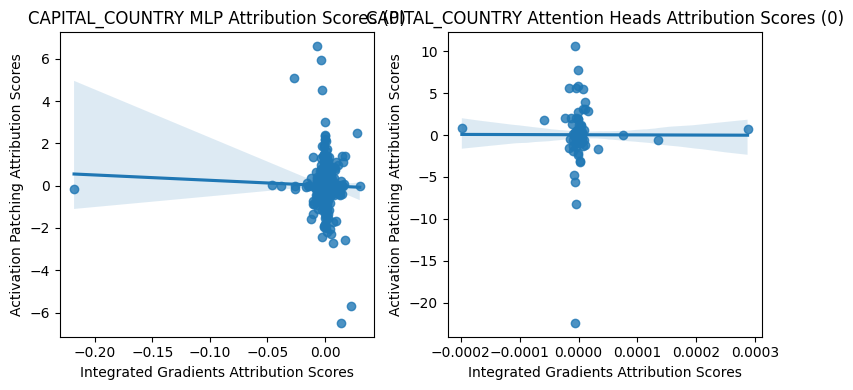

Correlation coefficient for neurons: -0.024295249434765003
Correlation coefficient for attention heads: -0.002275959522504568


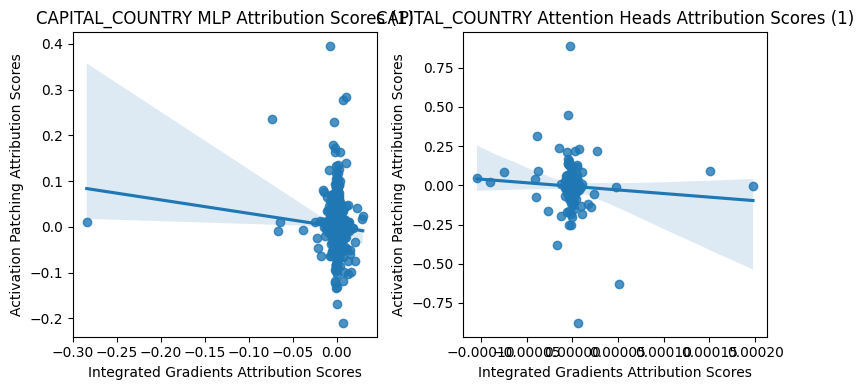

Correlation coefficient for neurons: -0.05200157852843071
Correlation coefficient for attention heads: -0.07878403425998999


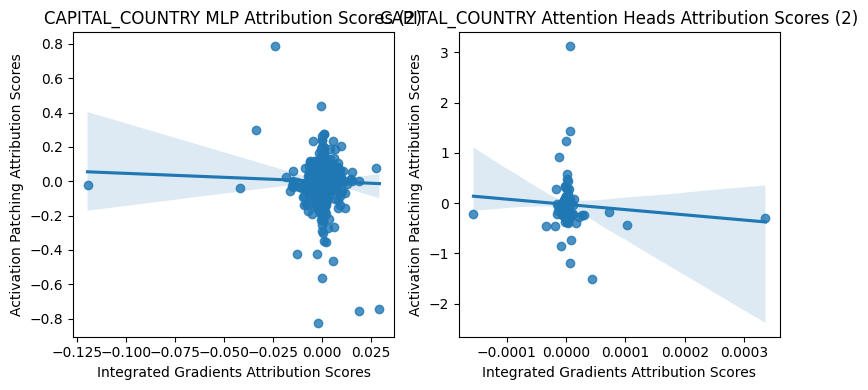

Correlation coefficient for neurons: -0.02142196079638009
Correlation coefficient for attention heads: -0.0860858925049072


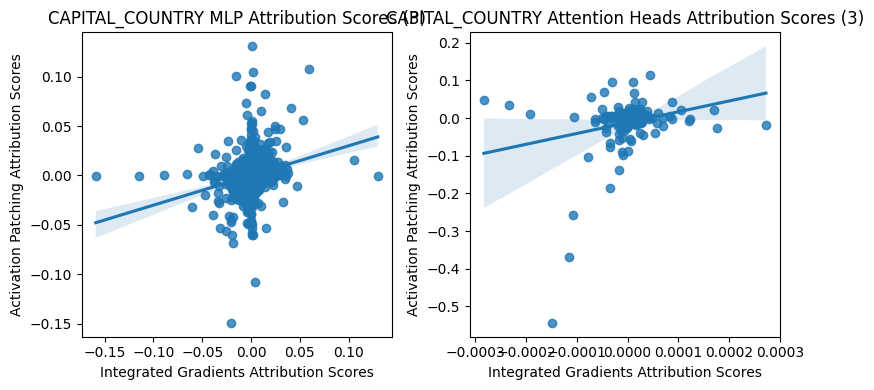

Correlation coefficient for neurons: 0.22315624028023648
Correlation coefficient for attention heads: 0.25410820078161933


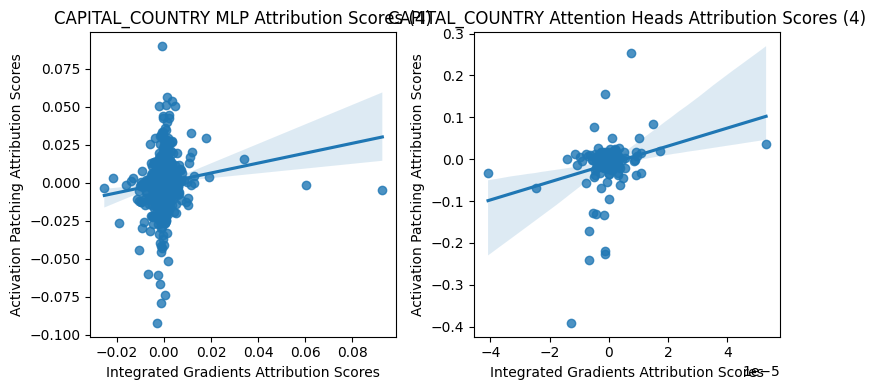

Correlation coefficient for neurons: 0.09456967452376902
Correlation coefficient for attention heads: 0.2676128944571196


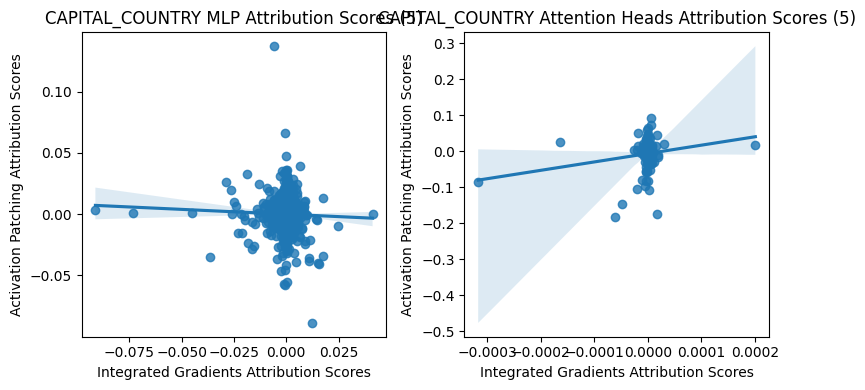

Correlation coefficient for neurons: -0.02766854718140715
Correlation coefficient for attention heads: 0.21279096673812514


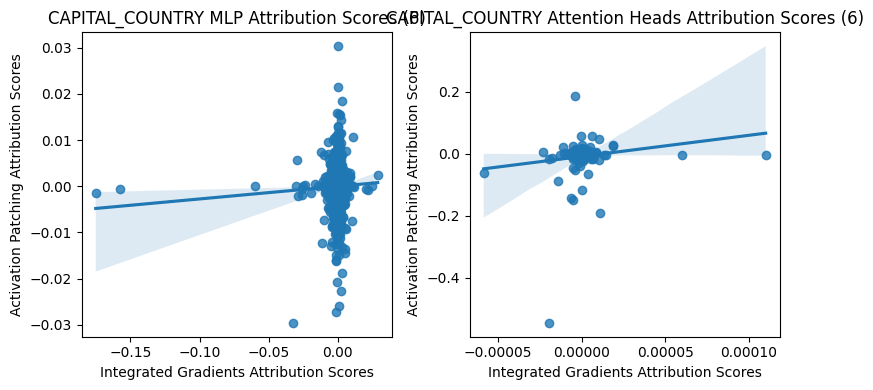

Correlation coefficient for neurons: 0.03368330100928562
Correlation coefficient for attention heads: 0.15676641048823692


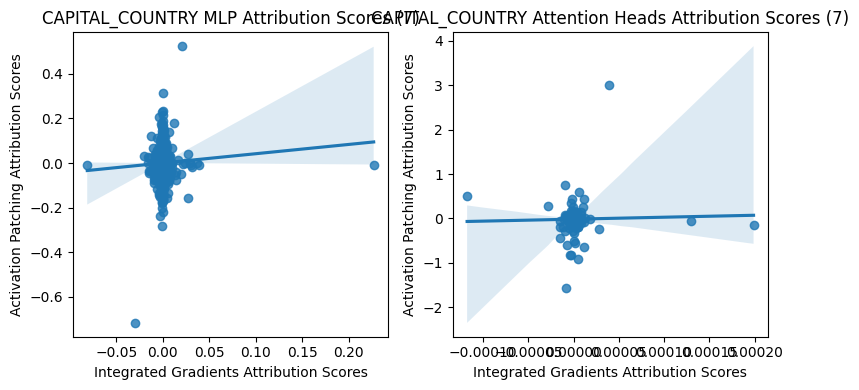

Correlation coefficient for neurons: 0.03963802674043124
Correlation coefficient for attention heads: 0.028685407618792264


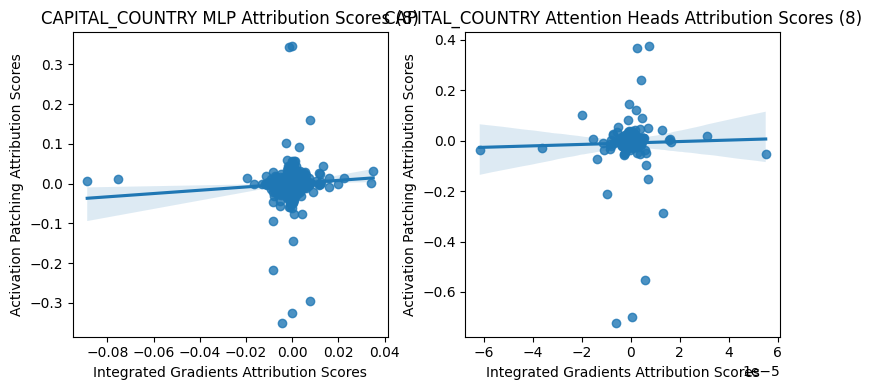

Correlation coefficient for neurons: 0.06544616939407105
Correlation coefficient for attention heads: 0.02341910638155913


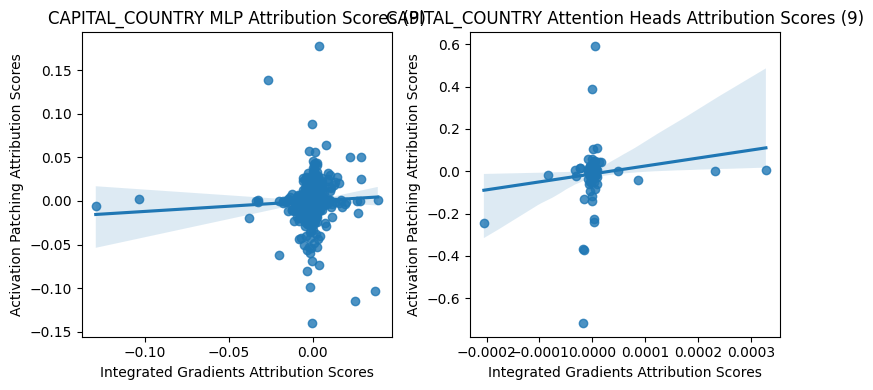

Correlation coefficient for neurons: 0.04169889233855514
Correlation coefficient for attention heads: 0.14162469009754855


In [138]:
plot_correlation(capital_country_ig_zero_mlp, capital_country_ap_mlp, capital_country_ig_zero_attn, capital_country_ap_attn, Task.CAPITAL_COUNTRY)

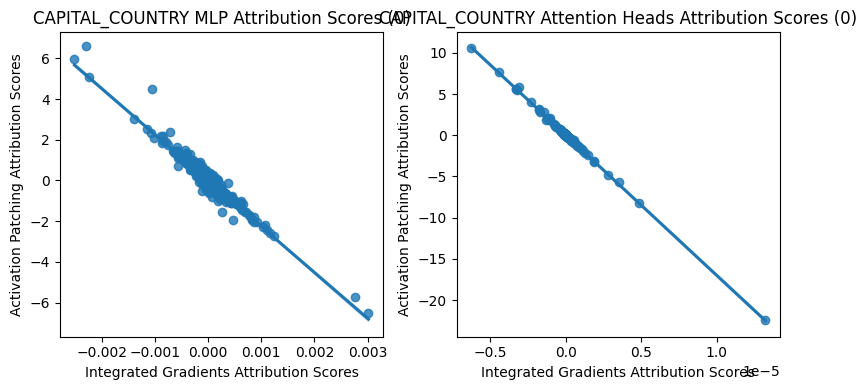

Correlation coefficient for neurons: -0.9799934665067876
Correlation coefficient for attention heads: -0.9994530296159567


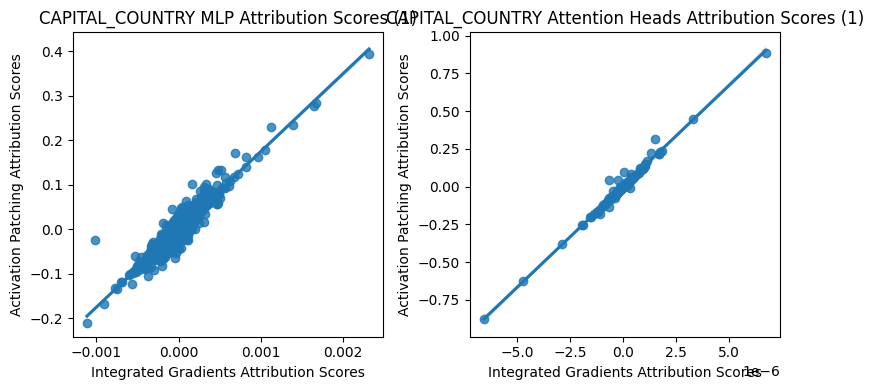

Correlation coefficient for neurons: 0.9658887791444335
Correlation coefficient for attention heads: 0.9914172032759089


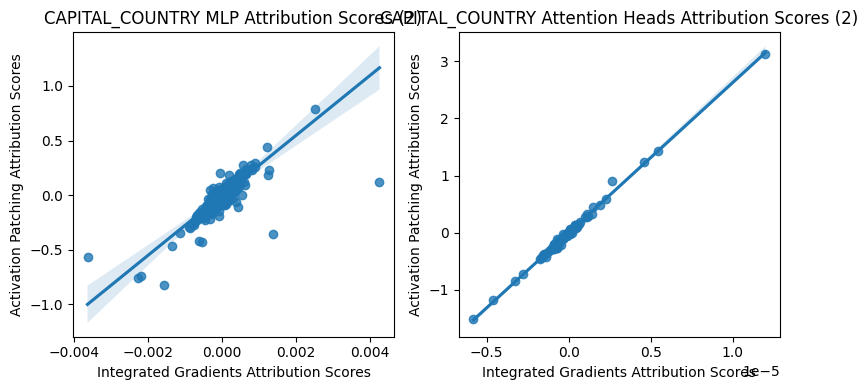

Correlation coefficient for neurons: 0.8785006138447461
Correlation coefficient for attention heads: 0.997433511209961


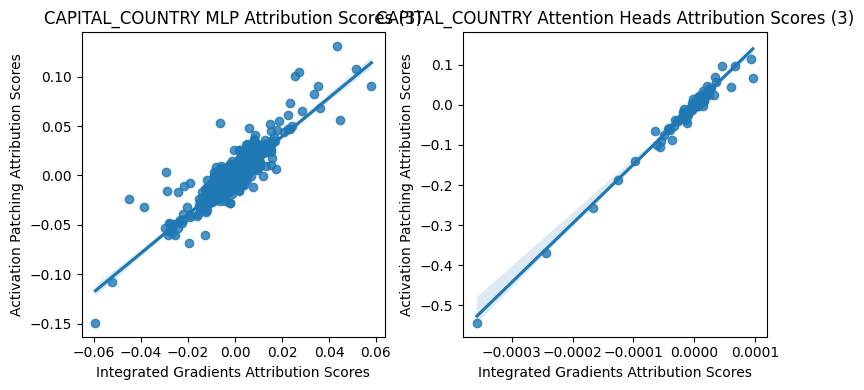

Correlation coefficient for neurons: 0.9007383534254303
Correlation coefficient for attention heads: 0.9869862682816243


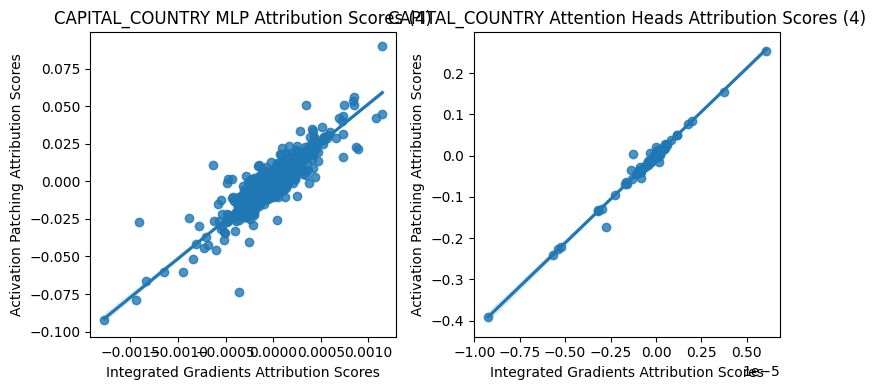

Correlation coefficient for neurons: 0.9323198857489192
Correlation coefficient for attention heads: 0.9910252438379731


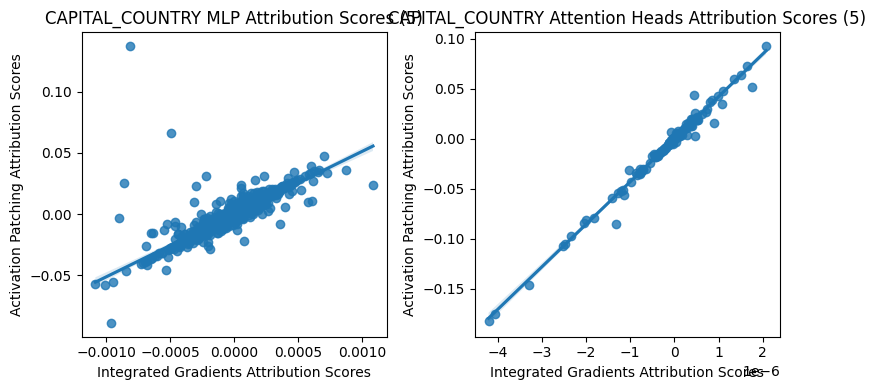

Correlation coefficient for neurons: 0.8760420038968695
Correlation coefficient for attention heads: 0.9913362248326645


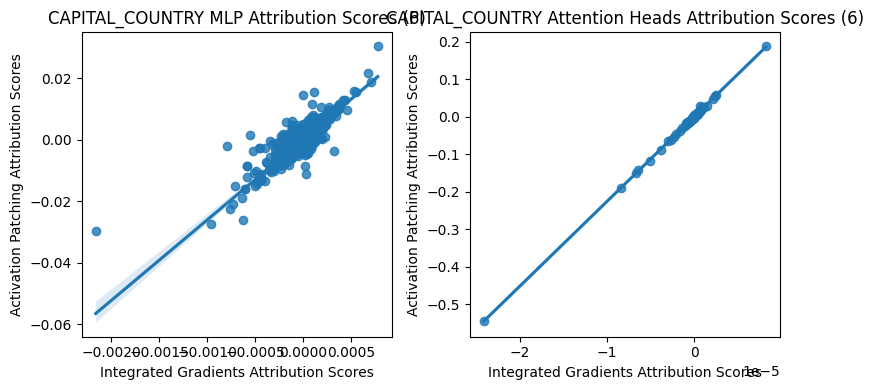

Correlation coefficient for neurons: 0.9301915065492695
Correlation coefficient for attention heads: 0.9995685384726163


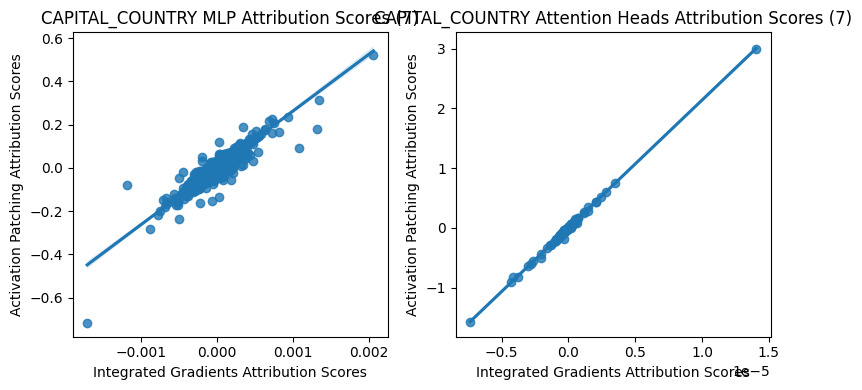

Correlation coefficient for neurons: 0.948719502391491
Correlation coefficient for attention heads: 0.9988895659744479


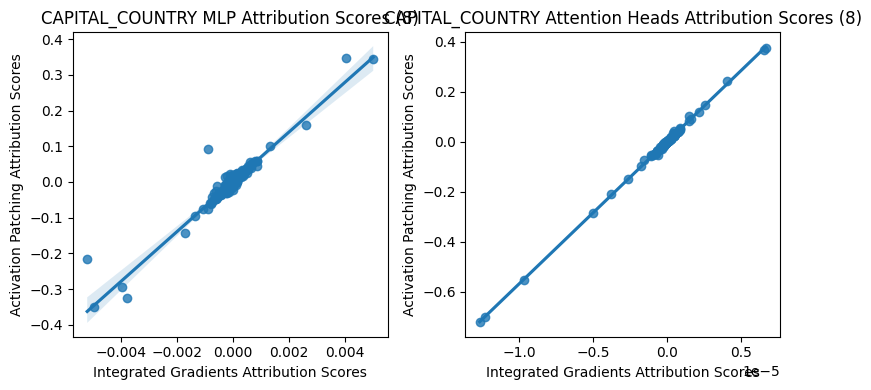

Correlation coefficient for neurons: 0.9664224328513882
Correlation coefficient for attention heads: 0.9994670549627225


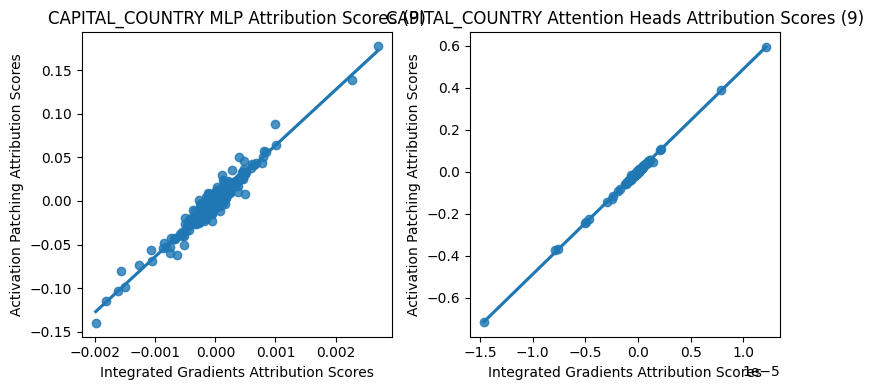

Correlation coefficient for neurons: 0.9781727057257313
Correlation coefficient for attention heads: 0.9995804380414065


In [ ]:
plot_correlation(capital_country_ig_mlp, capital_country_ap_mlp, capital_country_ig_attn, capital_country_ap_attn, Task.CAPITAL_COUNTRY)